##**Import library**

In [498]:
rm(list=ls())
set.seed(1234)
library(tidyverse)
library(lubridate)
#install.packages("stargazer")
library(stargazer)
#install.packages("broom")
library(broom)
#install.packages("TSstudio")
library(TSstudio)
#install.packages("ggplot2")
library(ggplot2)
#install.packages("psych")
library(psych)
#install.packages("mgcv")
library(mgcv)
#install.packages("partykit")
library(partykit)
#install.packages("rpart")
library("rpart")
#install.packages("reshape")
library("reshape")
#install.packages("coefplot")
library("coefplot")
#install.packages("mlr")
library("mlr")
library("MASS")

#**Regression Problem**

## **Load and process data**

**Data description** <br>
This dataset contains daily counts of rented bicycles from the bicycle rental company Capital-Bikeshare in Washington D.C., along with weather and seasonal information. The data was kindly made openly available by Capital-Bikeshare. Fanaee-T and Gama (2013)14 added weather data and season information. The goal is to predict how many bikes will be rented depending on the weather and the day. The data can be downloaded from the UCI Machine Learning Repository.

New features were added to the dataset and not all original features were used for the examples in this book. Here is the list of features that were used:


*  Count of bicycles including both casual and registered users. The count is used as the target in the regression task.
*   The season, either spring, summer, fall or winter.
*   Indicator whether the day was a holiday or not.
*   The year, either 2011 or 2012.
*   Number of days since the 01.01.2011 (the first day in the dataset). This feature was introduced to take account of the trend over time.
*   Indicator whether the day was a working day or weekend.
*   The weather situation on that day. One of: <br>
  1.   clear, few clouds, partly cloudy, cloudy
  2.   mist + clouds, mist + broken clouds, mist + few clouds, mist
  3.   light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds
  4.  heavy rain + ice pallets + thunderstorm + mist, snow + mist
*   Temperature in degrees Celsius.
*   Relative humidity in percent (0 to 100).
*   Wind speed in km per hour.

In [499]:
### Process Bike Data

bike = read.csv("https://github.com/pacayton/DS_397_Interpretable_ML/raw/main/Datasets/Bike_Sharing/day.csv", stringsAsFactors = FALSE)

bike$weekday = factor(bike$weekday, levels=0:6, labels = c('SUN', 'MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT'))
bike$holiday = factor(bike$holiday, levels = c(0,1), labels = c('NO HOLIDAY', 'HOLIDAY'))
bike$workingday = factor(bike$workingday, levels = c(0,1), labels = c('NO WORKING DAY', 'WORKING DAY'))
bike$season = factor(bike$season, levels = 1:4, labels = c('WINTER', 'SPRING', 'SUMMER', 'FALL'))
bike$weathersit = factor(bike$weathersit, levels = 1:3, labels = c('GOOD', 'MISTY', 'RAIN/SNOW/STORM'))
bike$mnth = factor(bike$mnth, levels = 1:12, labels = c('JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'))
bike$yr[bike$yr == 0] = 2011
bike$yr[bike$yr == 1] = 2012
bike$yr = factor(bike$yr)
bike$days_since_2011 = as.numeric(as.Date(bike$dteday)- min(as.Date(bike$dteday)))

# denormalize weather features:
# temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
bike$temp = bike$temp * (39 - (-8)) + (-8)
# atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
bike$atemp = bike$atemp * (50 - (16)) + (16)

#windspeed: Normalized wind speed. The values are divided to 67 (max)
bike$windspeed = 67 * bike$windspeed
#hum: Normalized humidity. The values are divided to 100 (max)
bike$hum = 100 * bike$hum

bike <- dplyr::select(bike, -instant, -dteday, -registered, -casual, -atemp)

bike.features.of.interest = c('season','holiday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'days_since_2011')

#Added variable
bike$days_since_2011 <- bike$days_since_2011 + 1
bike$days_in_year = bike$days_since_2011 %% 366
bike$days_in_year[bike$yr == 2012] <- bike$days_in_year[bike$yr == 2012] + 1
bike$log_cnt <- log(bike$cnt)

In [500]:
head(bike)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011,days_in_year,log_cnt
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,1,1,6.892642
2,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,2,2,6.685861
3,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,3,3,7.207119
4,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,4,4,7.353722
5,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,5,5,7.377759
6,WINTER,2011,JAN,NO HOLIDAY,THU,WORKING DAY,GOOD,1.604356,51.8261,6.000868,1606,6,6,7.381502


In [501]:
tail(bike)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011,days_in_year,log_cnt
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
726,WINTER,2012,DEC,NO HOLIDAY,WED,WORKING DAY,RAIN/SNOW/STORM,3.436651,82.3333,21.208582,441,726,361,6.089045
727,WINTER,2012,DEC,NO HOLIDAY,THU,WORKING DAY,MISTY,3.945849,65.2917,23.458911,2114,727,362,7.656337
728,WINTER,2012,DEC,NO HOLIDAY,FRI,WORKING DAY,MISTY,3.906651,59.0000,10.416557,3095,728,363,8.037543
729,WINTER,2012,DEC,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,3.906651,75.2917,8.333661,1341,729,364,7.201171
730,WINTER,2012,DEC,NO HOLIDAY,SUN,NO WORKING DAY,GOOD,4.024151,48.3333,23.500518,1796,730,365,7.493317
731,WINTER,2012,DEC,NO HOLIDAY,MON,WORKING DAY,MISTY,2.144151,57.7500,10.374682,2729,731,366,7.911691


In [502]:
#Trim features
bike <- bike[,c(1:3,6:10,11:14)]

## **Summary statistics and data visualization**

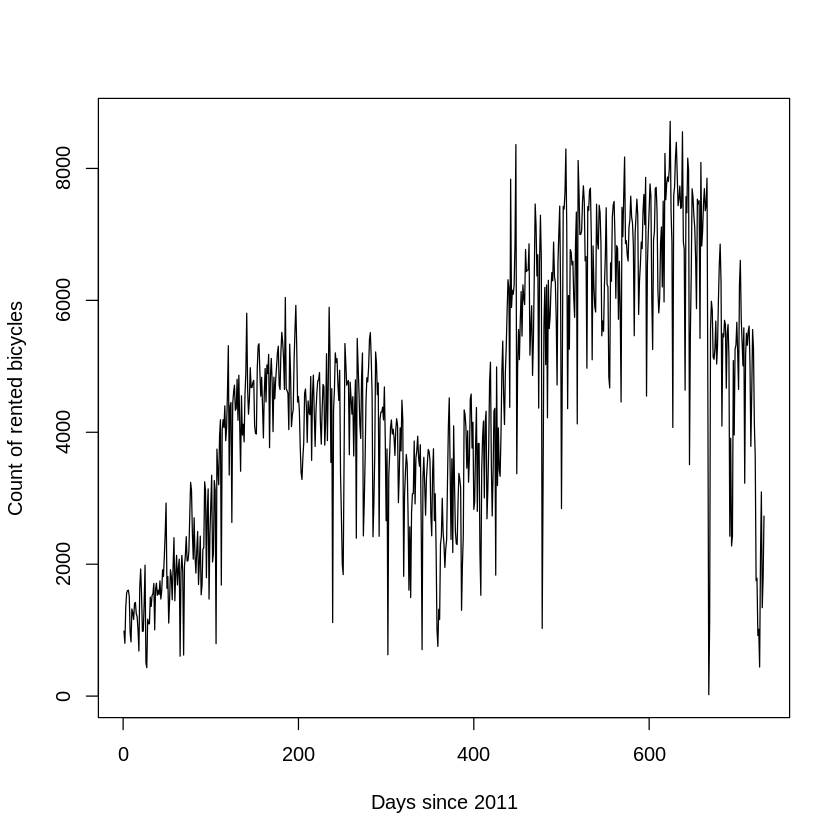

In [503]:
p00 <- plot(bike$days_since_2011,bike$cnt,type="l",xlab='Days since 2011',ylab='Count of rented bicycles')

In [504]:
bike_train <- bike[bike$days_since_2011<585,]
bike_test <- bike[bike$days_since_2011>=585,]

In [505]:
str(bike_train)

'data.frame':	584 obs. of  12 variables:
 $ season         : Factor w/ 4 levels "WINTER","SPRING",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ yr             : Factor w/ 2 levels "2011","2012": 1 1 1 1 1 1 1 1 1 1 ...
 $ mnth           : Factor w/ 12 levels "JAN","FEB","MAR",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ workingday     : Factor w/ 2 levels "NO WORKING DAY",..: 1 1 2 2 2 2 2 1 1 2 ...
 $ weathersit     : Factor w/ 3 levels "GOOD","MISTY",..: 2 2 1 1 1 1 2 2 1 1 ...
 $ temp           : num  8.18 9.08 1.23 1.4 2.67 ...
 $ hum            : num  80.6 69.6 43.7 59 43.7 ...
 $ windspeed      : num  10.7 16.7 16.6 10.7 12.5 ...
 $ cnt            : int  985 801 1349 1562 1600 1606 1510 959 822 1321 ...
 $ days_since_2011: num  1 2 3 4 5 6 7 8 9 10 ...
 $ days_in_year   : num  1 2 3 4 5 6 7 8 9 10 ...
 $ log_cnt        : num  6.89 6.69 7.21 7.35 7.38 ...


In [506]:
summary(bike_train)

    season       yr           mnth              workingday 
 WINTER:170   2011:365   JAN    : 62   NO WORKING DAY:184  
 SPRING:184   2012:219   MAR    : 62   WORKING DAY   :400  
 SUMMER:141              MAY    : 62                       
 FALL  : 89              JUL    : 62                       
                         APR    : 60                       
                         JUN    : 60                       
                         (Other):216                       
           weathersit       temp             hum          windspeed     
 GOOD           :377   Min.   :-5.221   Min.   : 0.00   Min.   : 1.500  
 MISTY          :189   1st Qu.: 7.774   1st Qu.:50.68   1st Qu.: 9.365  
 RAIN/SNOW/STORM: 18   Median :15.617   Median :62.21   Median :12.479  
                       Mean   :15.372   Mean   :62.31   Mean   :13.019  
                       3rd Qu.:23.030   3rd Qu.:73.03   3rd Qu.:15.699  
                       Max.   :32.498   Max.   :97.25   Max.   :34.000  
         

In [507]:
describe(bike_train)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
season*,1,584,2.255137,1.0386895,2.000000,2.194444,1.482600,1.000000,4.000000,3.000000,0.29318056,-1.10072493,0.04298128
yr*,2,584,1.375000,0.4845379,1.000000,1.344017,0.000000,1.000000,2.000000,1.000000,0.51507198,-1.73766752,0.02005032
mnth*,3,584,5.623288,3.2296661,5.000000,5.463675,2.965200,1.000000,12.000000,11.000000,0.35009826,-0.88287250,0.13364453
workingday*,4,584,1.684932,0.4649414,2.000000,1.730769,0.000000,1.000000,2.000000,1.000000,-0.79414244,-1.37167776,0.01923941
weathersit*,5,584,1.385274,0.5468032,1.000000,1.318376,0.000000,1.000000,3.000000,2.000000,1.02773503,0.01991321,0.02262688
temp,6,584,15.372436,8.8501574,15.617500,15.501582,11.352380,-5.220871,32.498349,37.719220,-0.08285887,-1.11679669,0.36622212
hum,7,584,62.314335,14.7917684,62.212850,62.220083,16.939743,0.000000,97.250000,97.250000,-0.07016325,-0.15371856,0.61208773
windspeed,8,584,13.018726,5.1042365,12.479152,12.686637,4.725179,1.500244,34.000021,32.499777,0.66464104,0.51284258,0.21121481
cnt,9,584,4153.599315,1788.8875748,4200.000000,4130.797009,1776.154800,431.000000,8362.000000,7931.000000,0.06640991,-0.68759917,74.02469455


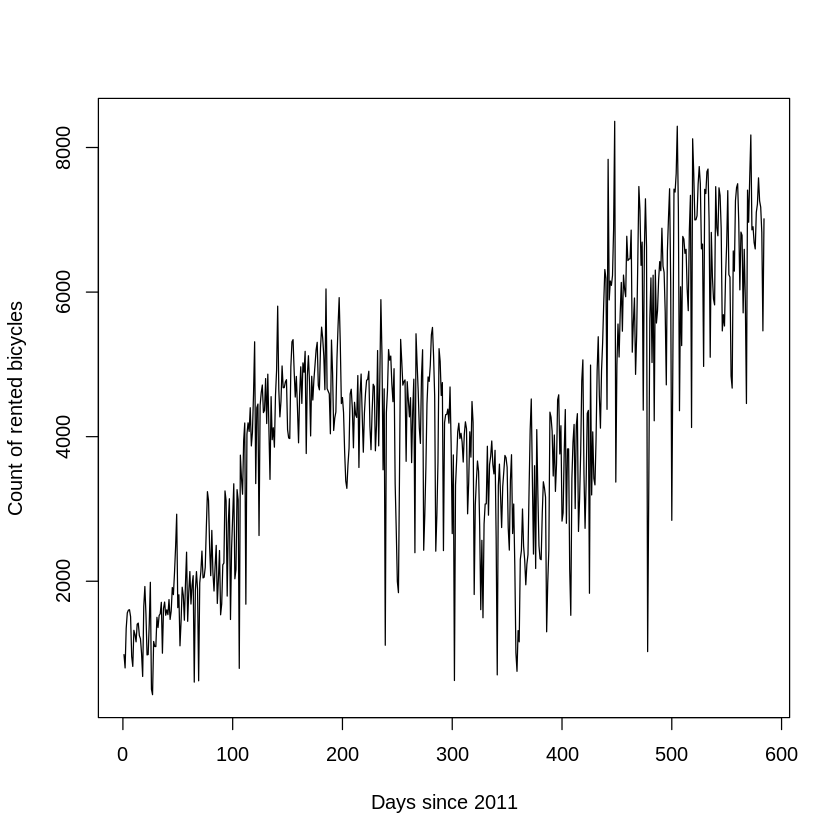

In [508]:
p0 <- plot(bike_train$days_since_2011,bike_train$cnt,type="l",xlab='Days since 2011',ylab='Count of rented bicycles')

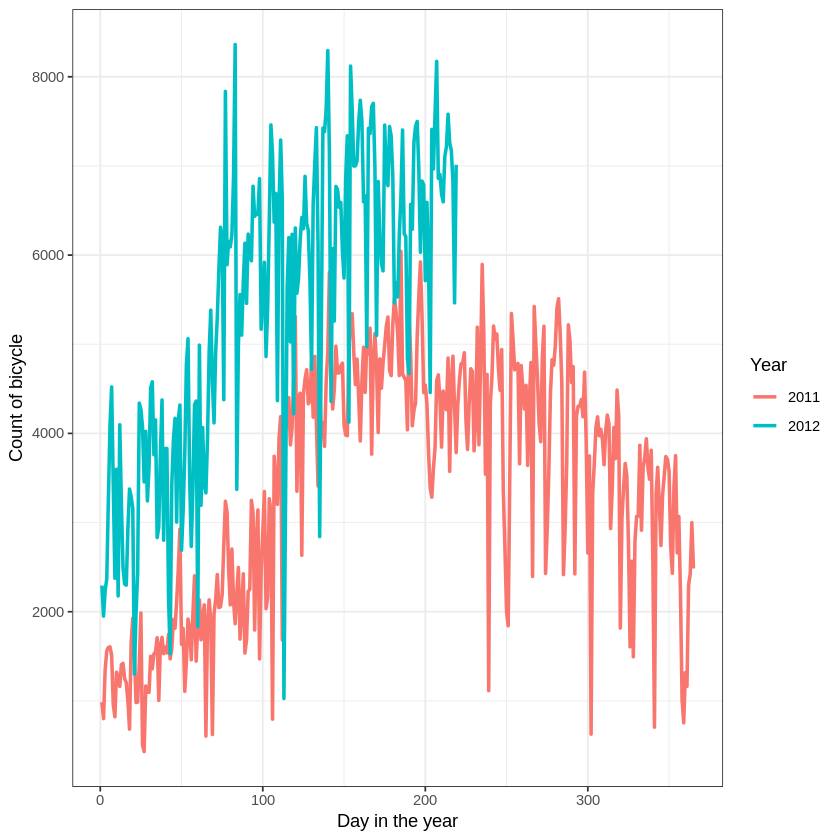

In [509]:
p1 <- ggplot(bike_train,aes(days_in_year,cnt,group=yr,color=yr)) + geom_line(size=1) + theme_bw()+ xlab('Day in the year')+ ylab('Count of bicycle') + scale_color_discrete(name = "Year")
p1

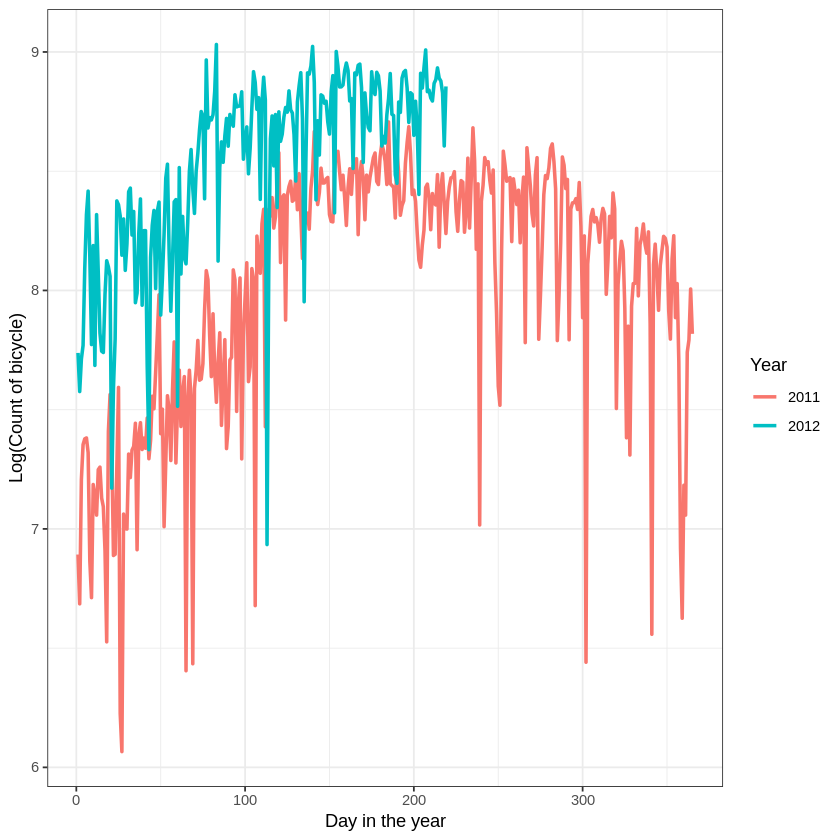

In [510]:
p2 <- ggplot(bike_train,aes(days_in_year,log_cnt,group=yr,color=yr)) + geom_line(size=1) + theme_bw() + xlab('Day in the year')+ ylab('Log(Count of bicycle)') + scale_color_discrete(name = "Year")
p2

In [511]:
extreme_yoy <- rbind(bike_train[bike_train$cnt == ave(bike_train$cnt, bike_train$yr, FUN=min),],bike_train[bike_train$cnt == ave(bike_train$cnt, bike_train$yr, FUN=max),])
extreme_yoy <- extreme_yoy[order(extreme_yoy$cnt),]
extreme_yoy

,season,yr,mnth,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011,days_in_year,log_cnt
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
27,WINTER,2011,JAN,WORKING DAY,GOOD,1.16500,68.7500,7.627079,431,27,27,6.066108
478,SPRING,2012,APR,NO WORKING DAY,RAIN/SNOW/STORM,10.64335,83.5417,23.084582,1027,478,113,6.934397
185,SUMMER,2011,JUL,NO WORKING DAY,MISTY,26.15335,63.7917,5.459106,6043,185,185,8.706656
448,SPRING,2012,MAR,WORKING DAY,MISTY,20.27835,69.4167,7.792100,8362,448,83,9.031453


In [512]:
extreme_across <- bike_train[order(bike_train$cnt,decreasing = TRUE)[1:10],]
extreme_across <- rbind(extreme_across,bike[order(bike_train$cnt,decreasing = FALSE)[1:10],])
extreme_across

,season,yr,mnth,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011,days_in_year,log_cnt
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
448,SPRING,2012,MAR,WORKING DAY,MISTY,20.278349,69.4167,7.792100,8362,448,83,9.031453
505,SPRING,2012,MAY,NO WORKING DAY,GOOD,20.200000,45.6250,5.626325,8294,505,140,9.023288
572,SUMMER,2012,JUL,WORKING DAY,GOOD,26.035849,45.0000,11.041600,8173,572,207,9.008591
519,SPRING,2012,JUN,NO WORKING DAY,GOOD,19.416651,54.9167,12.499654,8120,519,154,9.002085
442,WINTER,2012,MAR,NO WORKING DAY,MISTY,16.165849,75.5833,7.417168,7836,442,77,8.966484
525,SPRING,2012,JUN,WORKING DAY,GOOD,22.510849,46.7917,11.750661,7736,525,160,8.953640
533,SPRING,2012,JUN,NO WORKING DAY,GOOD,21.688349,50.4167,11.166689,7702,533,168,8.949235
532,SPRING,2012,JUN,WORKING DAY,GOOD,22.040849,58.9583,11.833339,7665,532,167,8.944420
520,SPRING,2012,JUN,NO WORKING DAY,GOOD,20.317500,49.3333,12.333829,7641,520,155,8.941284


In [513]:
table(bike_train$weathersit,bike_train$season)

                 
                  WINTER SPRING SUMMER FALL
  GOOD               108    113    104   52
  MISTY               59     68     33   29
  RAIN/SNOW/STORM      3      3      4    8

In [514]:
describe(bike_train[bike_train$weathersit=="RAIN/SNOW/STORM",])

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
season*,1,18,2.944444,1.1617544,3.000000,3.000000,1.4826000,1.000000,4.00000,3.000000,-0.53759030,-1.3164175,0.27382813
yr*,2,18,1.166667,0.3834825,1.000000,1.125000,0.0000000,1.000000,2.00000,1.000000,1.64187320,0.7462963,0.09038769
mnth*,3,18,7.666667,3.7573457,9.000000,7.812500,2.9652000,1.000000,12.00000,11.000000,-0.48316876,-1.4695190,0.88561489
workingday*,4,18,1.722222,0.4608886,2.000000,1.750000,0.0000000,1.000000,2.00000,1.000000,-0.91074739,-1.2297721,0.10863248
weathersit*,5,18,3.000000,0.0000000,3.000000,3.000000,0.0000000,3.000000,3.00000,0.000000,NaN,NaN,0.00000000
temp,6,18,12.439979,6.0824101,12.640826,12.493951,7.0868888,2.222500,21.79391,19.571411,-0.26028430,-1.1365121,1.43363780
hum,7,18,84.729567,21.8341522,90.073350,89.255656,4.7875378,0.000000,97.04170,97.041700,-3.21615454,9.6207182,5.14635902
windspeed,8,18,16.120303,5.4038155,16.464881,16.257701,5.0214431,6.500394,23.54186,17.041463,-0.23474524,-1.1954743,1.27369153
cnt,9,18,1820.388889,1020.1144191,1829.500000,1737.625000,1161.6171000,506.000000,4459.00000,3953.000000,0.63821652,0.1113792,240.44327445


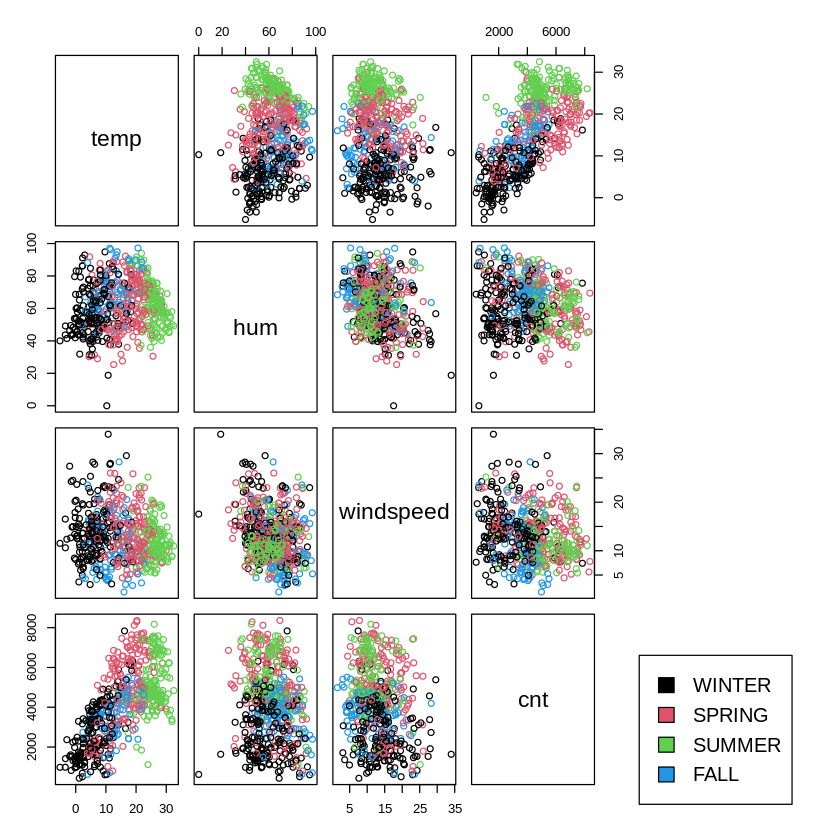

In [515]:
pairs(bike_train[,c(6:9)],col=bike_train$season, oma=c(3,3,3,15))
par(xpd = TRUE)
legend("bottomright", fill = unique(bike_train$season), legend = c( levels(bike_train$season)))

In [516]:
cor(bike_train[,c(6:9)])

,temp,hum,windspeed,cnt
temp,1.0000000,0.1186447,-0.1568526,0.6849055
hum,0.1186447,1.0000000,-0.2569349,-0.1275118
windspeed,-0.1568526,-0.2569349,1.0000000,-0.1963421
cnt,0.6849055,-0.1275118,-0.1963421,1.0000000


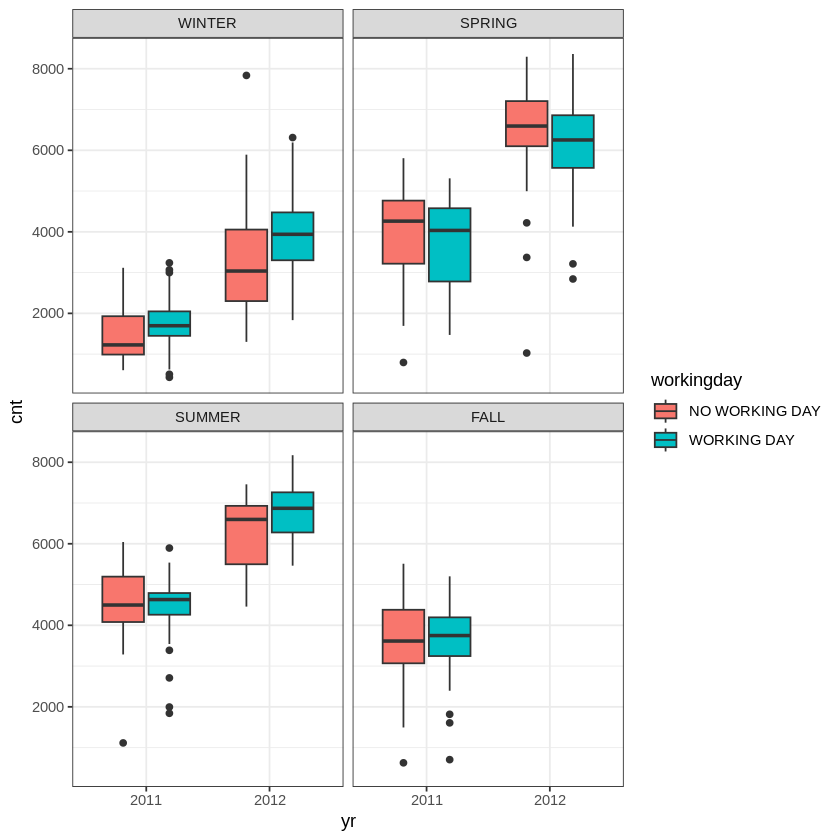

In [517]:
p5 <- ggplot(bike_train, aes(x=yr, y=cnt, fill=workingday)) +
    geom_boxplot() +
    facet_wrap(~season) + theme_bw()
p5

## **Modeling**

### Linear Regression

In [518]:
#Model development
base <- lm(cnt ~ days_in_year + I(days_in_year^2), data = bike_train)
model1 <- lm(cnt ~ yr + days_in_year + I(days_in_year^2), data = bike_train)
model2 <- lm(cnt ~ yr + days_in_year + I(days_in_year^2) + temp, data = bike_train)
model3 <- lm(cnt ~ yr + days_in_year + I(days_in_year^2) + temp + weathersit, data = bike_train)
model4 <- lm(cnt ~ yr + days_in_year + I(days_in_year^2) + temp + weathersit + hum + windspeed, data = bike_train)
model5 <- lm(cnt ~ yr + days_in_year + I(days_in_year^2) + temp + weathersit + hum + windspeed + season, data = bike_train)
model6 <- lm(cnt ~ yr + days_in_year + I(days_in_year^2) + temp + weathersit + hum + windspeed + season + workingday, data = bike_train)
stargazer(base,model1,model2,model3,model4,model5,model6, type = "text")


                                                                                                        Dependent variable:                                                                               
                          --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                cnt                                                                                       
                                    (1)                      (2)                      (3)                      (4)                      (5)                       (6)                       (7)           
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [519]:
lr_pred <- bike_train
lr_pred$model6 <- predict(model6)
mse1 <- mean((lr_pred$cnt-lr_pred$model6)^2)
mse1

[1] 486855.5

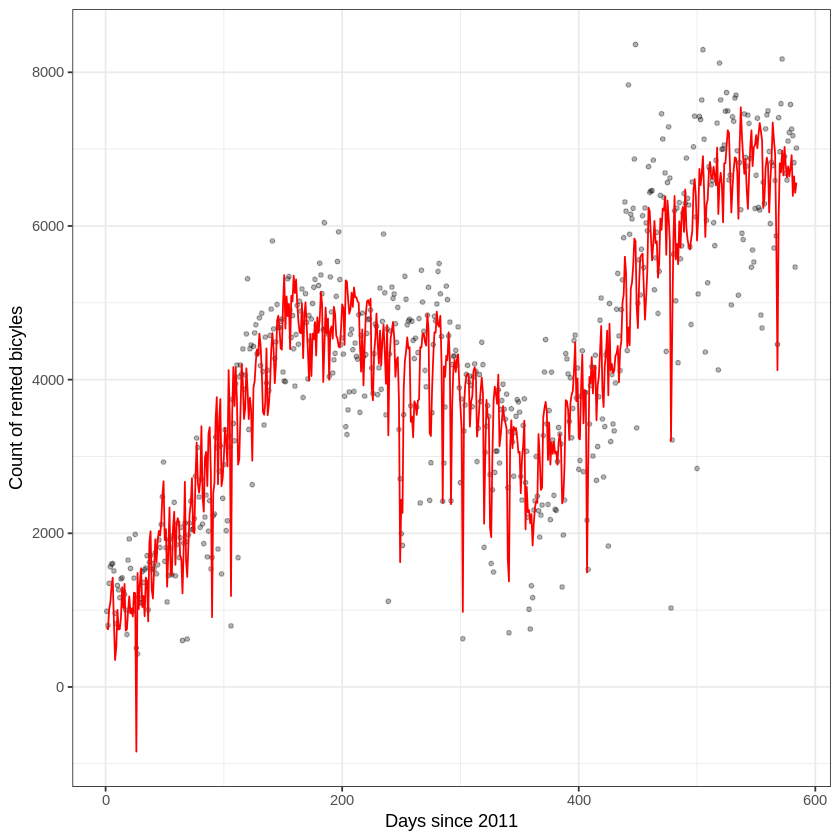

In [520]:
ggplot(bike_train) + geom_point(aes(x = days_since_2011, y = cnt), size = 1 , alpha = 0.3) + geom_line(aes(x = days_since_2011, y = predict(model6)), color = "red") + theme_bw() + xlab("Days since 2011") + ylab("Count of rented bicyles")

In [521]:
summary(model6)


Call:
lm(formula = cnt ~ yr + days_in_year + I(days_in_year^2) + temp + 
    weathersit + hum + windspeed + season + workingday, data = bike_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-2967.19  -370.14    46.86   457.07  3156.70 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                1.930e+03  2.231e+02   8.648  < 2e-16 ***
yr2012                     2.019e+03  6.798e+01  29.697  < 2e-16 ***
days_in_year               1.834e+01  3.020e+00   6.073 2.29e-09 ***
I(days_in_year^2)         -4.274e-02  7.599e-03  -5.625 2.91e-08 ***
temp                       6.931e+01  8.019e+00   8.644  < 2e-16 ***
weathersitMISTY           -3.635e+02  7.890e+01  -4.607 5.04e-06 ***
weathersitRAIN/SNOW/STORM -1.696e+03  1.934e+02  -8.768  < 2e-16 ***
hum                       -1.177e+01  2.749e+00  -4.282 2.17e-05 ***
windspeed                 -3.979e+01  6.234e+00  -6.383 3.61e-10 ***
seasonSPRING               5.906e+02  1.39

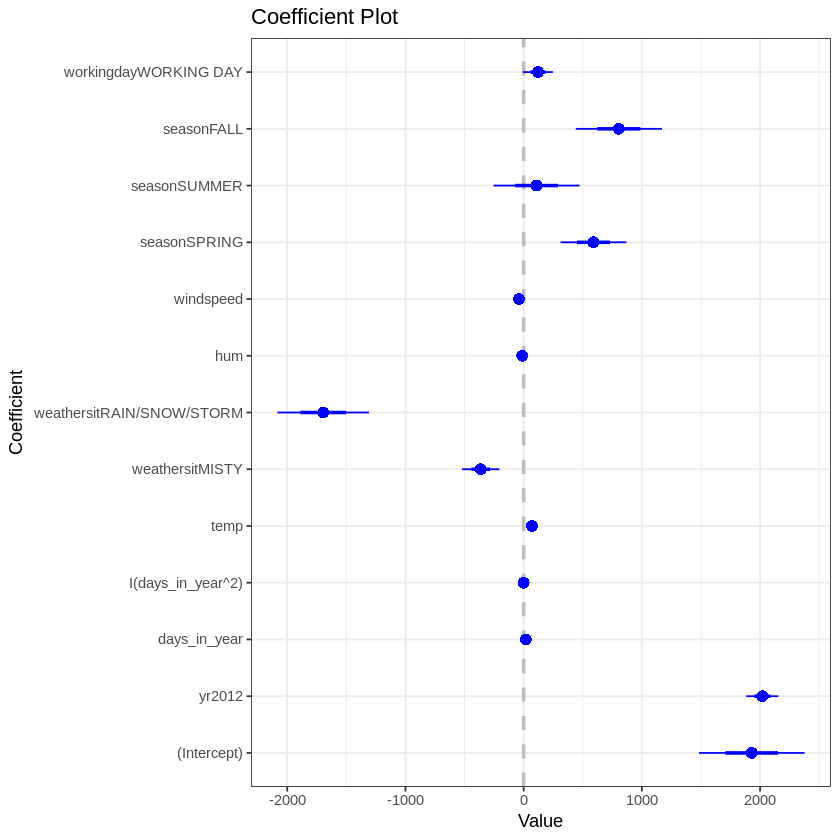

In [522]:
coefplot(model6) + theme_bw()

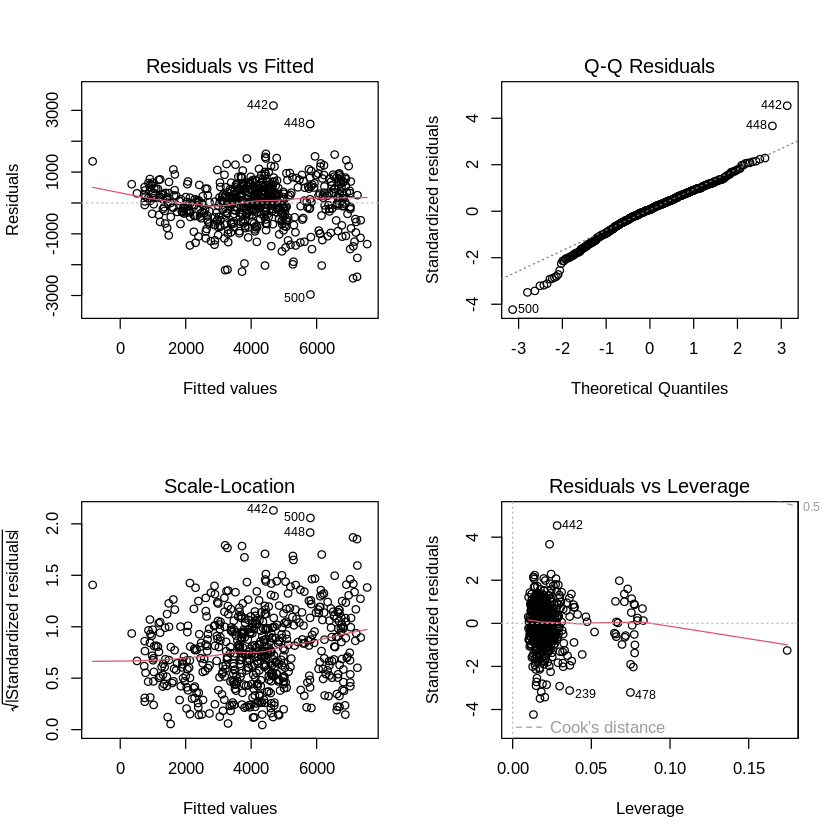

In [523]:
#Checking assumptions
par(mfrow=c(2,2))
plot(model6)

### Generalized Additive Model

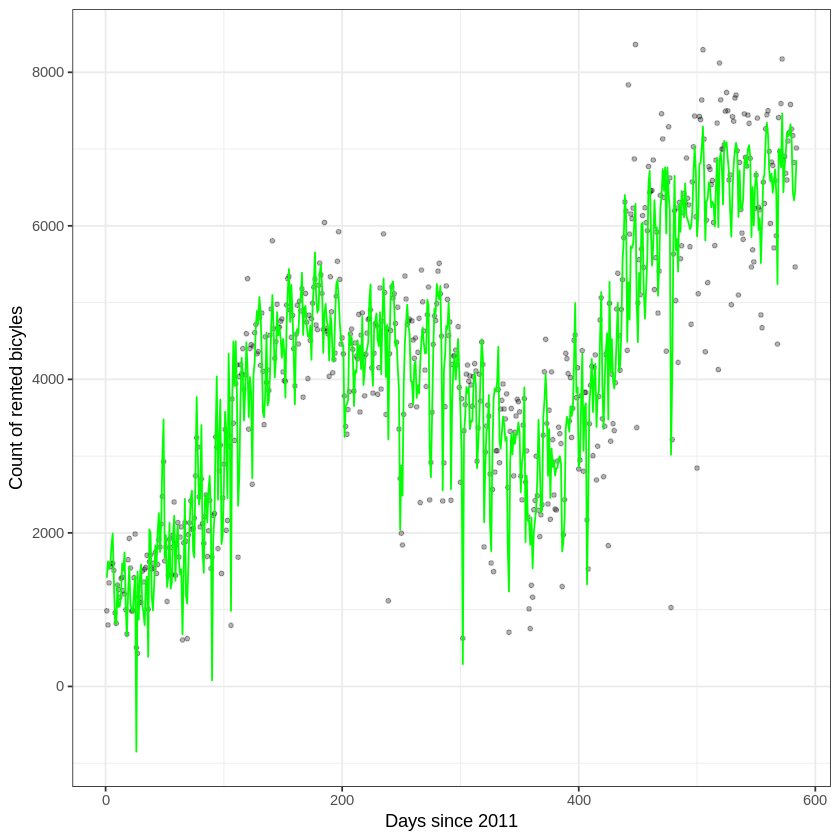

In [524]:
#Model development
gam_pred <- bike_train
base <- gam(cnt ~ s(days_since_2011), data = bike_train)
gam_pred$base <- predict(base)
mod1 <- gam(cnt ~ s(days_since_2011) + yr + s(temp) + weathersit + s(hum) + s(windspeed) + season, data = bike_train)
gam_pred$mod1 <- predict(mod1)
mod2 <- gam(cnt ~ s(days_since_2011) + yr + s(temp) + weathersit + s(hum) + s(windspeed) + season + workingday, data = bike_train)
gam_pred$mod2 <- predict(mod2)

ggplot(gam_pred) + geom_point(aes(x = days_since_2011, y = cnt), size = 1 , alpha = 0.3) + geom_line(aes(x = days_since_2011, y = mod2), color = "green") + theme_bw()  + xlab("Days since 2011") + ylab("Count of rented bicyles")

In [525]:
mse1 <- mean((gam_pred$cnt - gam_pred$base)^2)
mse2 <- mean((gam_pred$cnt - gam_pred$mod1)^2)
mse3 <- mean((gam_pred$cnt - gam_pred$mod2)^2)
print(c(mse1,mse2,mse3))

[1] 720295.2 309393.2 308494.3


In [526]:
summary(mod1)


Family: gaussian 
Link function: identity 

Formula:
cnt ~ s(days_since_2011) + yr + s(temp) + weathersit + s(hum) + 
    s(windspeed) + season

Parametric coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)                3404.42     143.98  23.646  < 2e-16 ***
yr2012                     1174.53     224.50   5.232 2.38e-07 ***
weathersitMISTY            -314.75      65.45  -4.809 1.95e-06 ***
weathersitRAIN/SNOW/STORM -1396.29     177.02  -7.888 1.63e-14 ***
seasonSPRING                415.55     132.02   3.148 0.001734 ** 
seasonSUMMER                641.73     174.07   3.687 0.000249 ***
seasonFALL                 1100.85     183.99   5.983 3.91e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                     edf Ref.df      F  p-value    
s(days_since_2011) 7.475  8.426  5.389 6.27e-07 ***
s(temp)            5.556  6.762 52.621  < 2e-16 ***
s(hum)             2.887  3

In [527]:
summary(mod2)


Family: gaussian 
Link function: identity 

Formula:
cnt ~ s(days_since_2011) + yr + s(temp) + weathersit + s(hum) + 
    s(windspeed) + season + workingday

Parametric coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)                3364.92     147.10  22.875  < 2e-16 ***
yr2012                     1171.46     224.59   5.216 2.58e-07 ***
weathersitMISTY            -322.04      65.64  -4.906 1.22e-06 ***
weathersitRAIN/SNOW/STORM -1406.27     177.07  -7.942 1.10e-14 ***
seasonSPRING                411.25     132.15   3.112 0.001954 ** 
seasonSUMMER                634.75     174.11   3.646 0.000292 ***
seasonFALL                 1096.03     184.24   5.949 4.77e-09 ***
workingdayWORKING DAY        68.75      51.38   1.338 0.181454    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                     edf Ref.df      F p-value    
s(days_since_2011) 7.503  8.444  5.485 4.2e-07 ***
s

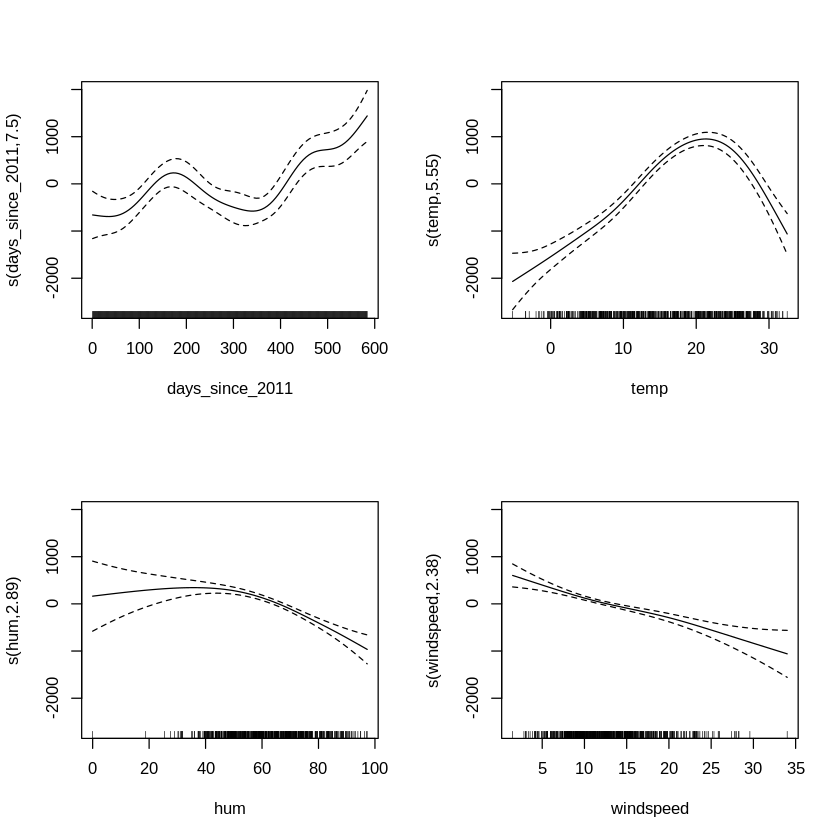

In [528]:
plot(mod2, pages = 1)

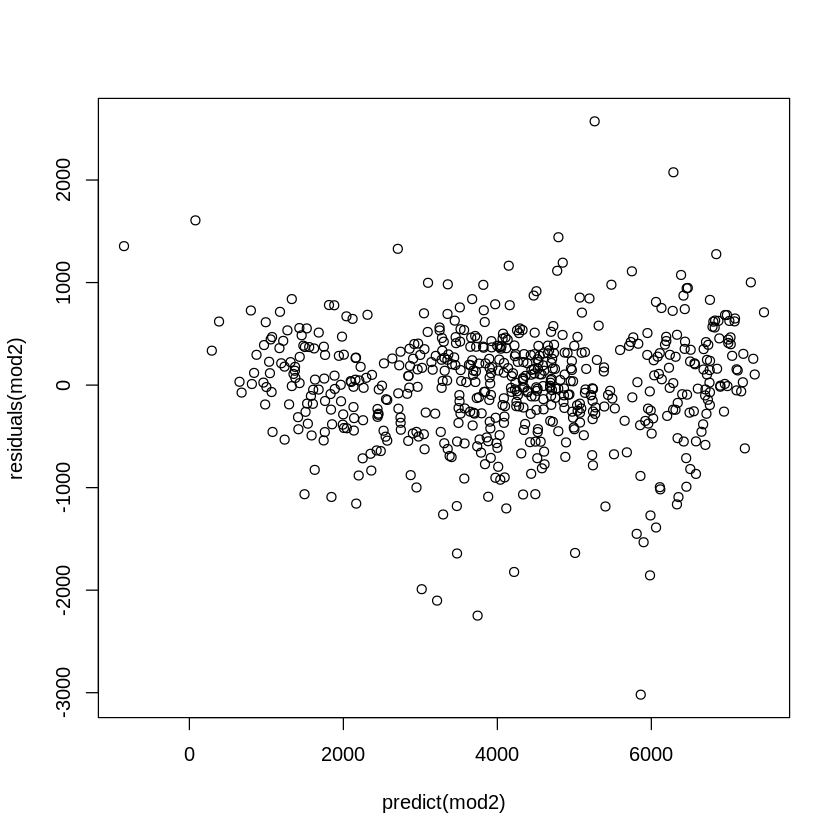

In [529]:
#Check assumptions
plot(predict(mod2),residuals(mod2))

[1] 5.438077e-12

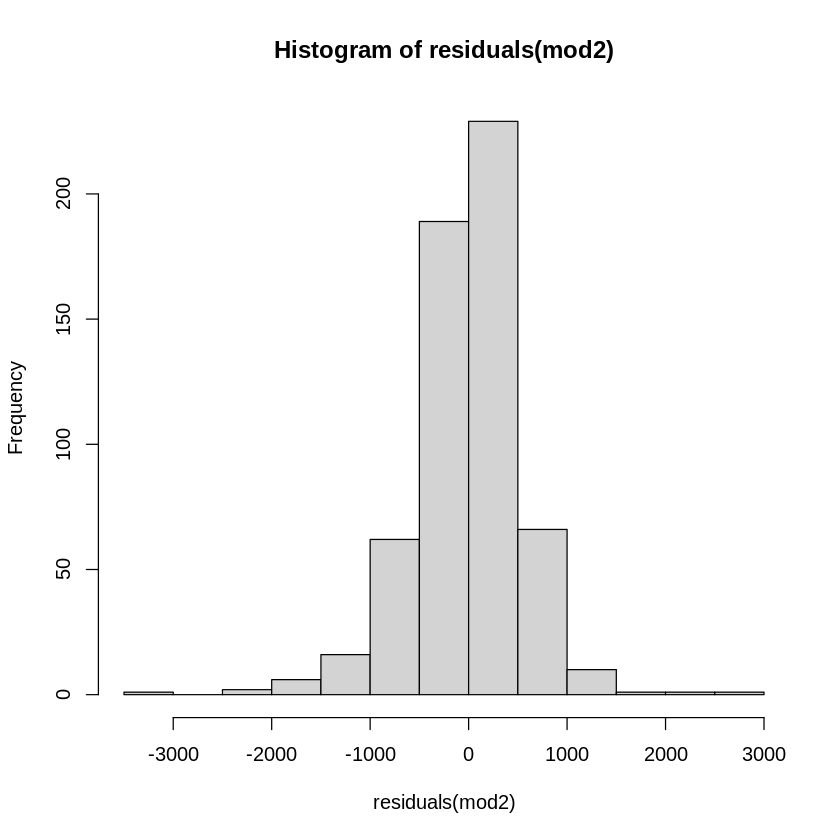

In [530]:
hist(residuals(mod2))
mean(residuals(mod2))

### Regression Tree, no boosting nor bagging

In [531]:
#Model development
rt_pred <- bike_train

base <- rpart(bike_train$cnt ~ yr + days_in_year , data = bike_train, method = 'anova', control = rpart.control(cp = 0, maxdepth = 4))
m1 <- rpart(bike_train$cnt ~ yr + days_in_year + temp + hum + season, data = bike_train, method = 'anova', control = rpart.control(cp = 0, maxdepth = 4))
m2 <- rpart(bike_train$cnt ~ yr + days_in_year + season, data = bike_train, method = 'anova', control = rpart.control(cp = 0, maxdepth = 4))
m3 <- rpart(bike_train$cnt ~ yr + days_in_year + season + temp + weathersit, data = bike_train, method = 'anova', control = rpart.control(cp = 0, maxdepth = 4))
m4 <- rpart(bike_train$cnt ~ yr + days_in_year + temp + weathersit + hum + windspeed + season, data = bike_train, method = 'anova', control = rpart.control(cp = 0, maxdepth = 4))

rt_pred$base <- predict(base)
rt_pred$m1 <- predict(m1)
rt_pred$m2 <- predict(m2)
rt_pred$m3 <- predict(m3)
rt_pred$m4 <- predict(m4)

mse1 <- mean((rt_pred$cnt - rt_pred$base)^2)
mse2 <- mean((rt_pred$cnt - rt_pred$m1)^2)
mse3 <- mean((rt_pred$cnt - rt_pred$m2)^2)
mse4 <- mean((rt_pred$cnt - rt_pred$m3)^2)
print(c(mse1,mse2,mse3,mse4))

[1] 629716.9 481338.9 667381.8 500863.1


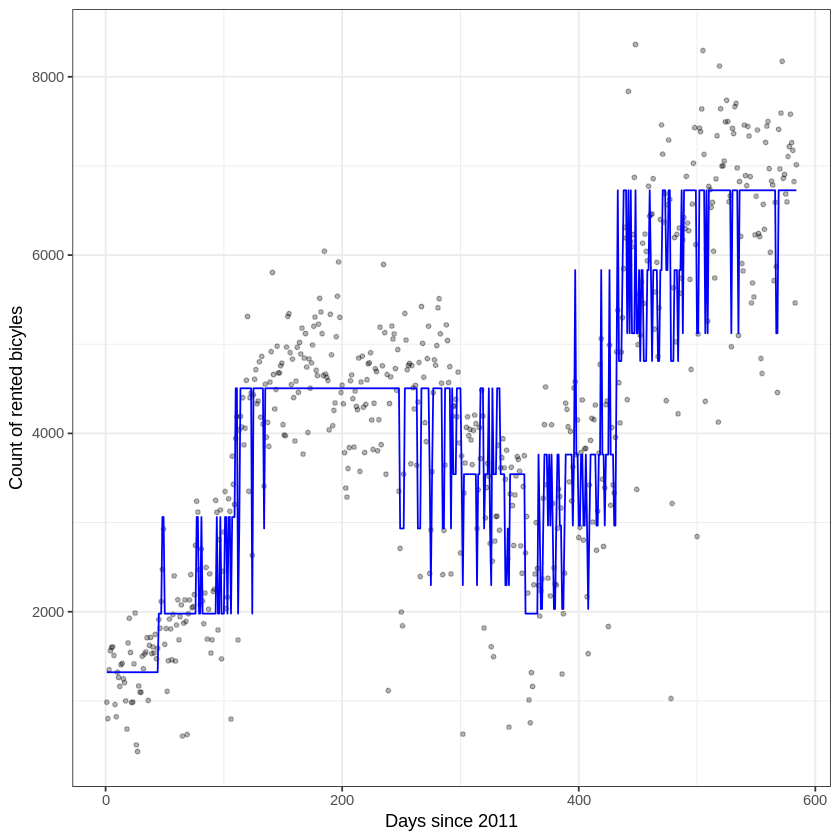

In [532]:
ggplot(rt_pred) + geom_point(aes(x = days_since_2011, y = cnt), size = 1 , alpha = 0.3) + geom_line(aes(x = days_since_2011, y = m1), color = "blue") + theme_bw() + xlab("Days since 2011") + ylab("Count of rented bicyles")

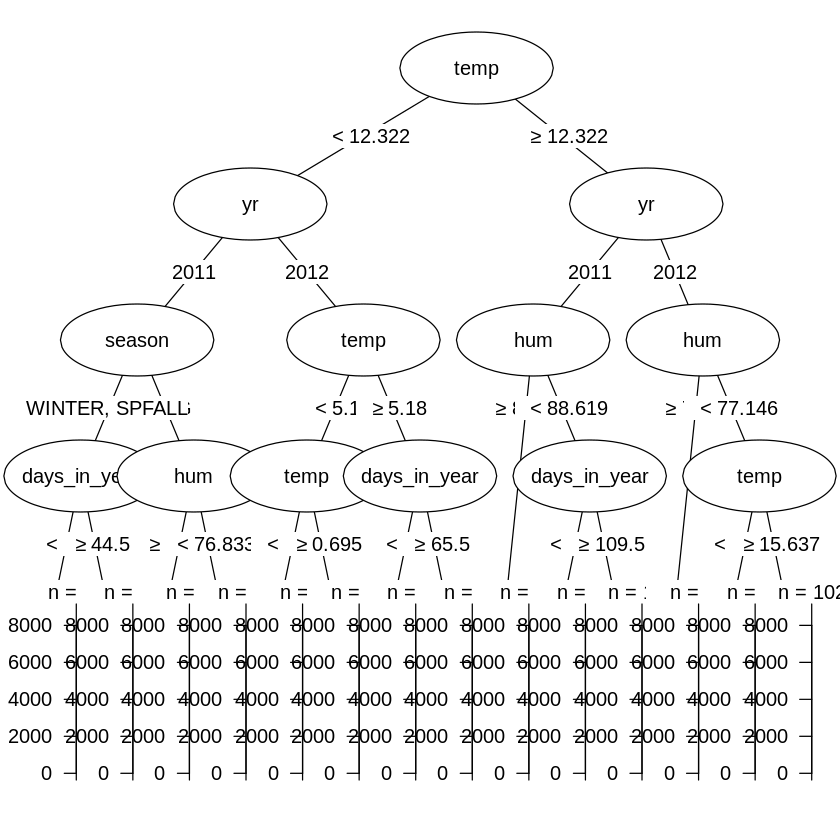

In [533]:
xp <- as.party(m1)
plot(xp, digits = 0, id = FALSE, terminal_panel = node_boxplot(xp, id = FALSE),
  inner_panel = node_inner(xp, id = FALSE, pval = FALSE)
  )

In [534]:
print(xp)


Model formula:
bike_train$cnt ~ yr + days_in_year + temp + hum + season

Fitted party:
[1] root
|   [2] temp < 12.32153
|   |   [3] yr in 2011
|   |   |   [4] season in WINTER, SPRING
|   |   |   |   [5] days_in_year < 44.5: 1321.659 (n = 44, err = 5443621.9)
|   |   |   |   [6] days_in_year >= 44.5: 1978.906 (n = 64, err = 20524075.4)
|   |   |   [7] season in FALL
|   |   |   |   [8] hum >= 76.8333: 2298.000 (n = 7, err = 10293134.0)
|   |   |   |   [9] hum < 76.8333: 3542.524 (n = 42, err = 14152010.5)
|   |   [10] yr in 2012
|   |   |   [11] temp < 5.17958
|   |   |   |   [12] temp < 0.695: 2030.714 (n = 7, err = 1235257.4)
|   |   |   |   [13] temp >= 0.695: 2966.524 (n = 21, err = 6497279.2)
|   |   |   [14] temp >= 5.17958
|   |   |   |   [15] days_in_year < 65.5: 3762.857 (n = 35, err = 14447930.3)
|   |   |   |   [16] days_in_year >= 65.5: 4811.733 (n = 15, err = 25578526.9)
|   [17] temp >= 12.32153
|   |   [18] yr in 2011
|   |   |   [19] hum >= 88.6187: 2933.867 (n = 15, e

In [535]:
xp2 <- as.party(base)
print(xp2)


Model formula:
bike_train$cnt ~ yr + days_in_year

Fitted party:
[1] root
|   [2] yr in 2011
|   |   [3] days_in_year < 106.5
|   |   |   [4] days_in_year < 69.5
|   |   |   |   [5] days_in_year < 36.5: 1259.389 (n = 36, err = 4616226.6)
|   |   |   |   [6] days_in_year >= 36.5: 1753.970 (n = 33, err = 6579329.0)
|   |   |   [7] days_in_year >= 69.5
|   |   |   |   [8] days_in_year < 92.5: 2248.217 (n = 23, err = 3903403.9)
|   |   |   |   [9] days_in_year >= 92.5: 2547.214 (n = 14, err = 8065372.4)
|   |   [10] days_in_year >= 106.5
|   |   |   [11] days_in_year >= 299.5
|   |   |   |   [12] days_in_year >= 356.5: 1851.333 (n = 9, err = 5047494.0)
|   |   |   |   [13] days_in_year < 356.5: 3278.263 (n = 57, err = 37096329.1)
|   |   |   [14] days_in_year < 299.5
|   |   |   |   [15] days_in_year < 113.5: 3461.286 (n = 7, err = 4402343.4)
|   |   |   |   [16] days_in_year >= 113.5: 4434.204 (n = 186, err = 105789944.2)
|   [17] yr in 2012
|   |   [18] days_in_year < 70.5
|   |   |   [

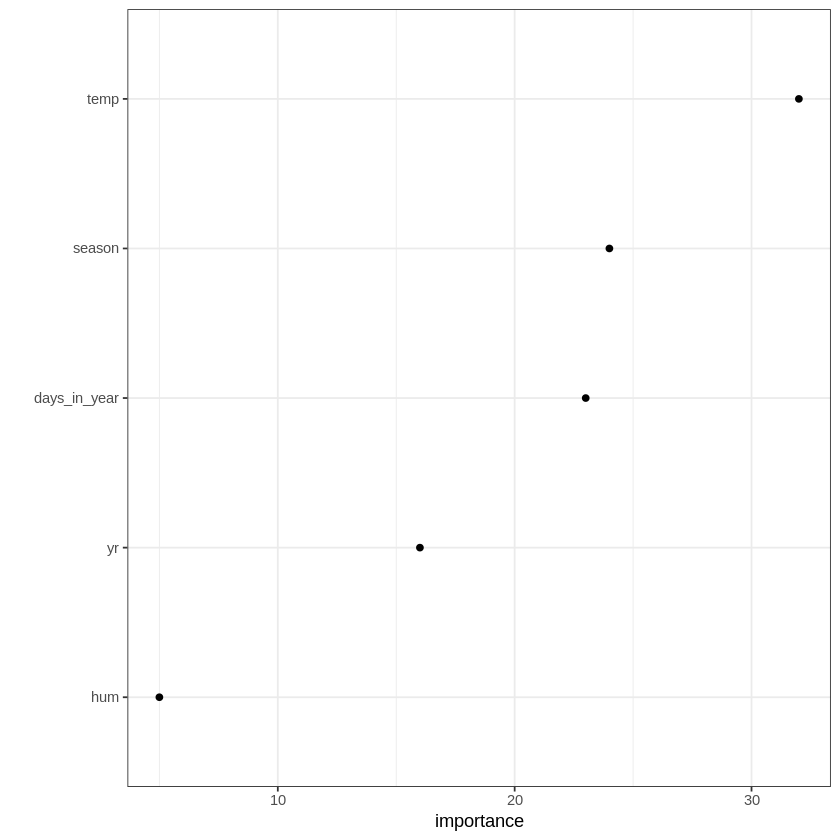

In [536]:
imp = round(100 * m1$variable.importance / sum(m1$variable.importance),0)
imp.df = data.frame(feature = names(imp), importance = imp)
imp.df$feature = factor(imp.df$feature, levels = as.character(imp.df$feature)[order(imp.df$importance)])
ggplot(imp.df) + geom_point(aes(x = importance, y = feature)) +
  scale_y_discrete("") + theme_bw()

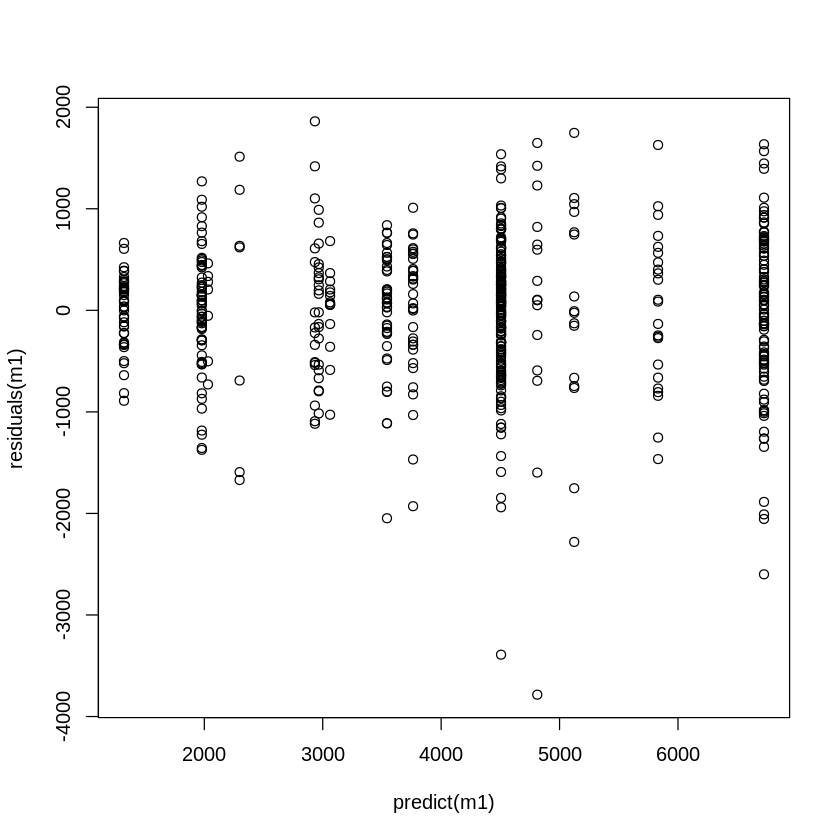

In [537]:
#Checking assumptions
plot(predict(m1),residuals(m1))

[1] 1.767718e-13

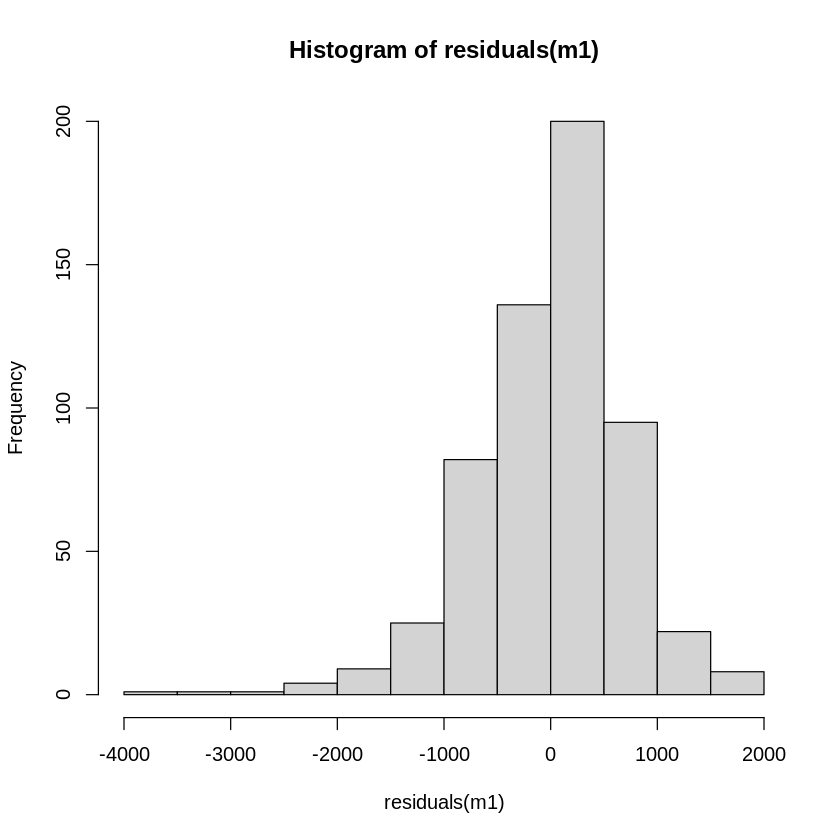

In [538]:
hist(residuals(m1))
mean(residuals(m1))

##Test data

In [539]:
bike_test$lm1 <- predict(model6, newdata = bike_test)
bike_test$gam1 <- predict(mod2, newdata = bike_test)
bike_test$rt1 <- predict(m1, newdata = bike_test)
head(bike_test)

,season,yr,mnth,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011,days_in_year,log_cnt,lm1,gam1,rt1
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl[1d]>,<dbl>
585,SUMMER,2012,AUG,WORKING DAY,MISTY,26.58415,70.3750,7.832836,7273,585,220,8.891924,6483.296,6946.171,6726.471
586,SUMMER,2012,AUG,WORKING DAY,MISTY,27.25000,67.2917,7.416900,7534,586,221,8.927181,6581.779,6928.801,6726.471
587,SUMMER,2012,AUG,WORKING DAY,GOOD,27.52415,62.0417,10.458700,7286,587,222,8.893710,6904.445,7167.457,6726.471
588,SUMMER,2012,AUG,WORKING DAY,MISTY,25.64415,71.5833,16.000471,5786,588,223,8.663196,6077.138,6754.664,6726.471
589,SUMMER,2012,AUG,NO WORKING DAY,MISTY,24.54750,73.2917,13.834093,6299,589,224,8.748146,5945.301,6883.916,6726.471
590,SUMMER,2012,AUG,NO WORKING DAY,GOOD,24.93915,53.0417,8.208304,6544,590,225,8.786304,6797.293,7881.392,6726.471


In [540]:
mse_lm <- mean((bike_test$cnt-bike_test$lm1)^2)
mse_gam <- mean((bike_test$cnt-bike_test$gam1)^2)
mse_rt <- mean((bike_test$cnt-bike_test$rt1)^2)
print(c(mse_lm,mse_gam,mse_rt))

[1] 1418241 6167666 1466248


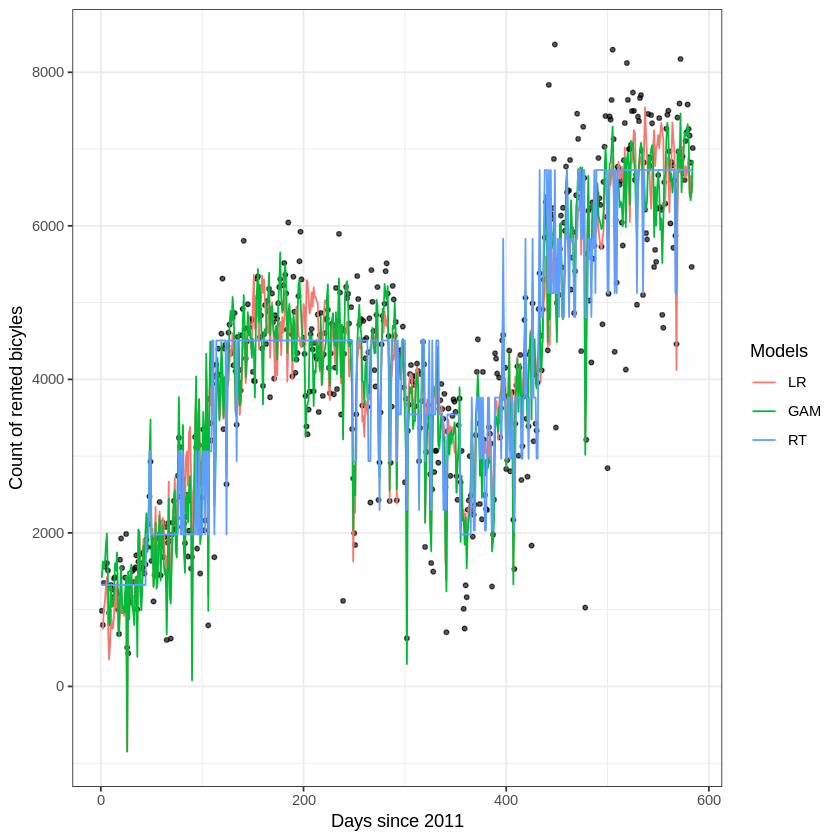

In [541]:
bike_train$lm1 <- predict(model6)
bike_train$gam1 <- predict(mod2)
bike_train$rt1 <- predict(m1)
temp <- bike_train[,c("cnt","days_since_2011","lm1","gam1","rt1")]
plot_data <- melt(temp, id.vars = c("cnt","days_since_2011"), variable.names = c("lm1","gam1","rt1"))
ggplot(plot_data) + geom_point(aes(x = days_since_2011, y = cnt), size = 1 , alpha = 0.3) + geom_line(aes(x = days_since_2011, y = value, color = variable)) + theme_bw() + guides(color = guide_legend(title = "Models")) +  scale_color_discrete(labels = c("LR","GAM","RT")) + xlab("Days since 2011") + ylab("Count of rented bicyles")

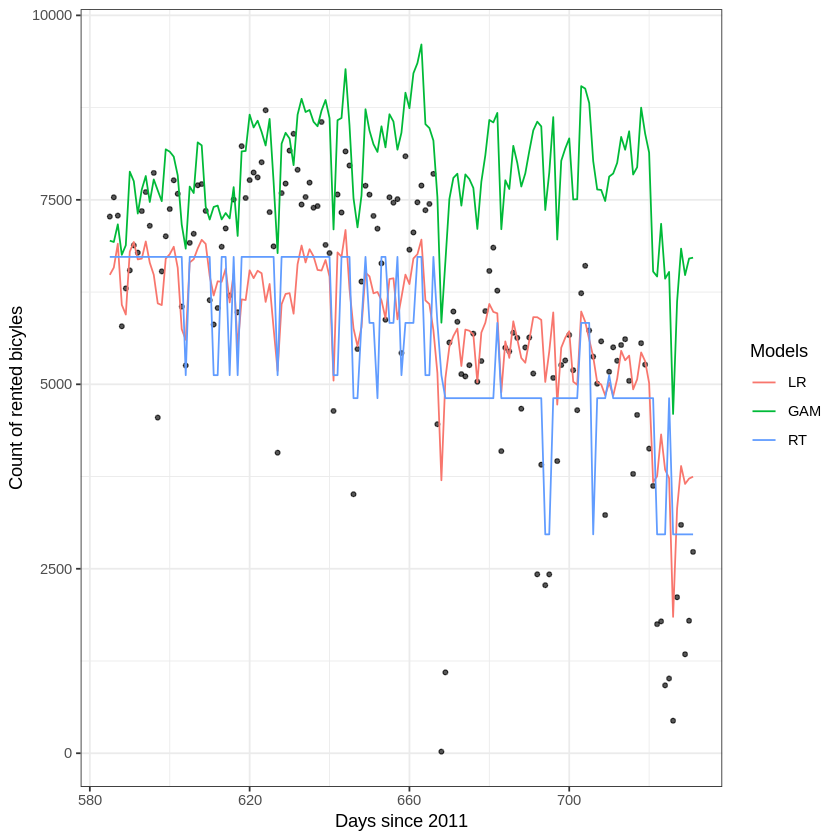

In [542]:
temp <- bike_test[,c("cnt","days_since_2011","lm1","gam1","rt1")]
plot_data <- melt(temp, id.vars = c("cnt","days_since_2011"), variable.names = c("lm1","gam1","rt1"))
ggplot(plot_data) + geom_point(aes(x = days_since_2011, y = cnt), size = 1 , alpha = 0.3) + geom_line(aes(x = days_since_2011, y = value, color = variable)) + theme_bw() + guides(color = guide_legend(title = "Models")) +  scale_color_discrete(labels = c("LR","GAM","RT")) + xlab("Days since 2011") + ylab("Count of rented bicyles")

#**Classification Problem**

##Load and process data

**Data description** <br>
The cervical cancer dataset contains indicators and risk factors for predicting whether a woman will get cervical cancer. The features include demographic data (such as age), lifestyle, and medical history. The data can be downloaded from the UCI Machine Learning repository and is described by Fernandes, Cardoso, and Fernandes (2017).

The subset of data features used in the book’s examples are:

* Age in years
* Number of sexual partners
* First sexual intercourse (age in years)
* Number of pregnancies
* Smoking yes or no
* Smoking (in years)
* Hormonal contraceptives yes or no
* Hormonal contraceptives (in years)
* Intrauterine device yes or no (IUD)
* Number of years with an intrauterine device (IUD)
* Has patient ever had a sexually transmitted disease (STD) yes or no
* Number of STD diagnoses
* Time since first STD diagnosis
* Time since last STD diagnosis
* The biopsy results “Healthy” or “Cancer”. Target outcome.

In [543]:
### Process cervical cancer Data

cervical = read.csv("https://github.com/pacayton/DS_397_Interpretable_ML/raw/refs/heads/main/Datasets/Cervical_Cancer_Risk_Factors/risk_factors_cervical_cancer.csv", na.strings = c('?'), stringsAsFactors = FALSE)

  ## subset variables
  cervical = dplyr::select(cervical, Age, Number.of.sexual.partners, First.sexual.intercourse,
  Smokes, Hormonal.Contraceptives, STDs..number.,Biopsy)

  mlr::makeClassifTask(id='cervical', data = cervical, target = 'Biopsy')

head(cervical)

Supervised task: cervical
Type: classif
Target: Biopsy
Observations: 858
Features:
   numerics     factors     ordered functionals 
          6           0           0           0 
Missings: TRUE
Has weights: FALSE
Has blocking: FALSE
Has coordinates: FALSE
Classes: 2
  0   1 
803  55 
Positive class: 0

,Age,Number.of.sexual.partners,First.sexual.intercourse,Smokes,Hormonal.Contraceptives,STDs..number.,Biopsy
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,18,4,15,0,0,0,0
2,15,1,14,0,0,0,0
3,34,1,NA,0,0,0,0
4,52,5,16,1,1,0,0
5,46,3,21,0,1,0,0
6,42,3,23,0,0,0,0


In [544]:
tail(cervical)

,Age,Number.of.sexual.partners,First.sexual.intercourse,Smokes,Hormonal.Contraceptives,STDs..number.,Biopsy
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
853,43,3,17,0,1,0,0
854,34,3,18,0,0,0,0
855,32,2,19,0,1,0,0
856,25,2,17,0,1,0,0
857,33,2,24,0,1,0,0
858,29,2,20,0,1,0,0


In [545]:
#Added feature
cervical$yr_gap <- cervical$Age - cervical$First.sexual.intercourse

head(cervical)

,Age,Number.of.sexual.partners,First.sexual.intercourse,Smokes,Hormonal.Contraceptives,STDs..number.,Biopsy,yr_gap
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,18,4,15,0,0,0,0,3
2,15,1,14,0,0,0,0,1
3,34,1,NA,0,0,0,0,NA
4,52,5,16,1,1,0,0,36
5,46,3,21,0,1,0,0,25
6,42,3,23,0,0,0,0,19


## **Summary statistics and data visualization**

In [546]:
cervical_train <- cervical[1:686,]
cervical_test <- cervical[687:858,]

#remove instance with missing data
cervical_train <- cervical_train[complete.cases(cervical_train),]
cervical_test <- cervical_test[complete.cases(cervical_test),]

#Remove redundant entry based on difference between age and first sexual intercourse
cervical_train <- cervical_train[cervical_train$yr_gap>=0,]
cervical_test <- cervical_test[cervical_test$yr_gap>=0,]

#Checking
makeClassifTask(id='cervical_train', data = cervical_train, target = 'Biopsy')
makeClassifTask(id='cervical_test', data = cervical_test, target = 'Biopsy')

Supervised task: cervical_train
Type: classif
Target: Biopsy
Observations: 573
Features:
   numerics     factors     ordered functionals 
          7           0           0           0 
Missings: FALSE
Has weights: FALSE
Has blocking: FALSE
Has coordinates: FALSE
Classes: 2
  0   1 
531  42 
Positive class: 0

Supervised task: cervical_test
Type: classif
Target: Biopsy
Observations: 138
Features:
   numerics     factors     ordered functionals 
          7           0           0           0 
Missings: FALSE
Has weights: FALSE
Has blocking: FALSE
Has coordinates: FALSE
Classes: 2
  0   1 
129   9 
Positive class: 0

In [547]:
str(cervical_train)

'data.frame':	573 obs. of  8 variables:
 $ Age                      : int  18 15 52 46 42 51 26 45 44 44 ...
 $ Number.of.sexual.partners: num  4 1 5 3 3 3 1 1 3 3 ...
 $ First.sexual.intercourse : num  15 14 16 21 23 17 26 20 15 26 ...
 $ Smokes                   : num  0 0 1 0 0 1 0 0 1 0 ...
 $ Hormonal.Contraceptives  : num  0 0 1 1 0 0 1 0 0 1 ...
 $ STDs..number.            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Biopsy                   : int  0 0 0 0 0 1 0 0 0 0 ...
 $ yr_gap                   : num  3 1 36 25 19 34 0 25 29 18 ...


In [548]:
summary(cervical_train)

      Age        Number.of.sexual.partners First.sexual.intercourse
 Min.   :13.00   Min.   : 1.000            Min.   :10.00           
 1st Qu.:20.00   1st Qu.: 1.000            1st Qu.:15.00           
 Median :26.00   Median : 2.000            Median :17.00           
 Mean   :27.35   Mean   : 2.462            Mean   :17.18           
 3rd Qu.:33.00   3rd Qu.: 3.000            3rd Qu.:18.00           
 Max.   :84.00   Max.   :28.000            Max.   :32.00           
     Smokes       Hormonal.Contraceptives STDs..number.        Biopsy      
 Min.   :0.0000   Min.   :0.0000          Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.0000          1st Qu.:0.0000   1st Qu.:0.0000  
 Median :0.0000   Median :1.0000          Median :0.0000   Median :0.0000  
 Mean   :0.1396   Mean   :0.6562          Mean   :0.1693   Mean   :0.0733  
 3rd Qu.:0.0000   3rd Qu.:1.0000          3rd Qu.:0.0000   3rd Qu.:0.0000  
 Max.   :1.0000   Max.   :1.0000          Max.   :4.0000   Max.   :1

In [549]:
describe(cervical_train)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Age,1,573,27.35253054,9.1417345,26,26.42483660,8.8956,13,84,71,1.5151645,4.901992,0.38190144
Number.of.sexual.partners,2,573,2.46247818,1.6399958,2,2.27886710,1.4826,1,28,27,6.9864176,101.012070,0.06851181
First.sexual.intercourse,3,573,17.17975567,2.9198157,17,16.83006536,2.9652,10,32,22,1.5906484,4.100556,0.12197705
Smokes,4,573,0.13961606,0.3468911,0,0.05010893,0.0000,0,1,1,2.0741669,2.306202,0.01449158
Hormonal.Contraceptives,5,573,0.65619546,0.4753918,1,0.69498911,0.0000,0,1,1,-0.6559762,-1.572430,0.01985978
STDs..number.,6,573,0.16928447,0.5587502,0,0.00000000,0.0000,0,4,4,3.5168382,12.430379,0.02334212
Biopsy,7,573,0.07329843,0.2608534,0,0.00000000,0.0000,0,1,1,3.2658713,8.681075,0.01089731
yr_gap,8,573,10.17277487,8.5793189,8,9.10457516,7.4130,0,64,64,1.8220676,6.241716,0.35840619


In [550]:
describe(cervical_train[cervical_train$Biopsy == 1,])

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Age,1,42,29.1904762,9.5566044,27.5,28.08823529,9.6369,17,52,35,0.7682517,-0.4417660,1.47461607
Number.of.sexual.partners,2,42,2.3095238,1.1150434,2.0,2.20588235,1.4826,1,5,4,0.6254742,-0.3474114,0.17205493
First.sexual.intercourse,3,42,17.1904762,2.7071549,17.0,16.97058824,1.4826,11,29,18,1.8049362,7.0020239,0.41772307
Smokes,4,42,0.1666667,0.3771955,0.0,0.08823529,0.0000,0,1,1,1.7253485,1.0023810,0.05820252
Hormonal.Contraceptives,5,42,0.7142857,0.4572300,1.0,0.76470588,0.0000,0,1,1,-0.9150042,-1.1893991,0.07055211
STDs..number.,6,42,0.3095238,0.6803190,0.0,0.14705882,0.0000,0,2,2,1.8248973,1.6489169,0.10497550
Biopsy,7,42,1.0000000,0.0000000,1.0,1.00000000,0.0000,1,1,0,NaN,NaN,0.00000000
yr_gap,8,42,12.0000000,9.4765436,9.0,10.88235294,8.1543,1,34,33,0.8017083,-0.4498775,1.46226242


In [551]:
describe(cervical_train[cervical_train$Biopsy == 0,])

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Age,1,531,27.2071563,9.1016495,26,26.29176471,8.8956,13,84,71,1.5819749,5.454048,0.39497795
Number.of.sexual.partners,2,531,2.4745763,1.6746764,2,2.28470588,1.4826,1,28,27,7.0534792,99.984734,0.07267477
First.sexual.intercourse,3,531,17.1789077,2.9383617,17,16.81882353,2.9652,10,32,22,1.5726674,3.900742,0.12751404
Smokes,4,531,0.1374765,0.3446744,0,0.04705882,0.0000,0,1,1,2.0996098,2.412916,0.01495759
Hormonal.Contraceptives,5,531,0.6516008,0.4769125,1,0.68941176,0.0000,0,1,1,-0.6345619,-1.600334,0.02069624
STDs..number.,6,531,0.1581921,0.5472260,0,0.00000000,0.0000,0,4,4,3.7301216,14.188313,0.02374759
Biopsy,7,531,0.0000000,0.0000000,0,0.00000000,0.0000,0,0,0,NaN,NaN,0.00000000
yr_gap,8,531,10.0282486,8.4973443,8,8.97647059,7.4130,0,64,64,1.9238792,7.077801,0.36875334


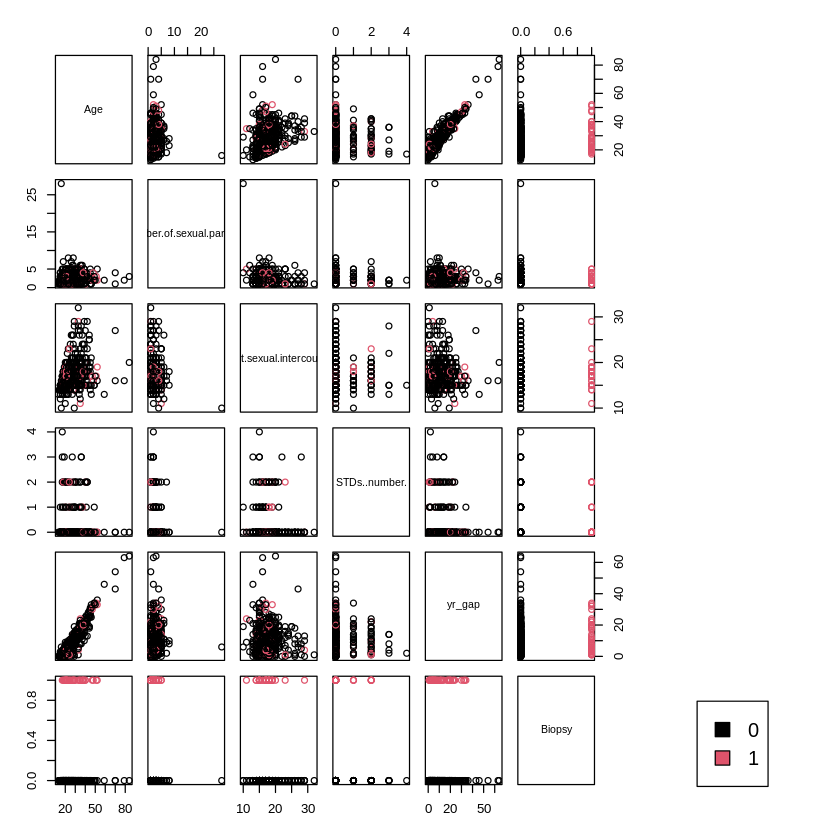

In [552]:
pairs(cervical_train[,c(1:3,6,8,7)],col=as.factor(cervical_train$Biopsy), oma=c(3,3,3,15))
par(xpd = TRUE)
legend("bottomright", fill = unique(as.factor(cervical_train$Biopsy)), legend = c( levels(as.factor(cervical_train$Biopsy))))

In [553]:
cor(cervical_train[,c(1:3,6,8)], use = "complete.obs")

,Age,Number.of.sexual.partners,First.sexual.intercourse,STDs..number.,yr_gap
Age,1.000000000,0.07877874,0.34639211,-0.003831773,0.947666533
Number.of.sexual.partners,0.078778742,1.00000000,-0.16342936,-0.022627799,0.139563289
First.sexual.intercourse,0.346392107,-0.16342936,1.00000000,0.011320013,0.028767898
STDs..number.,-0.003831773,-0.02262780,0.01132001,1.000000000,-0.007935525
yr_gap,0.947666533,0.13956329,0.02876790,-0.007935525,1.000000000


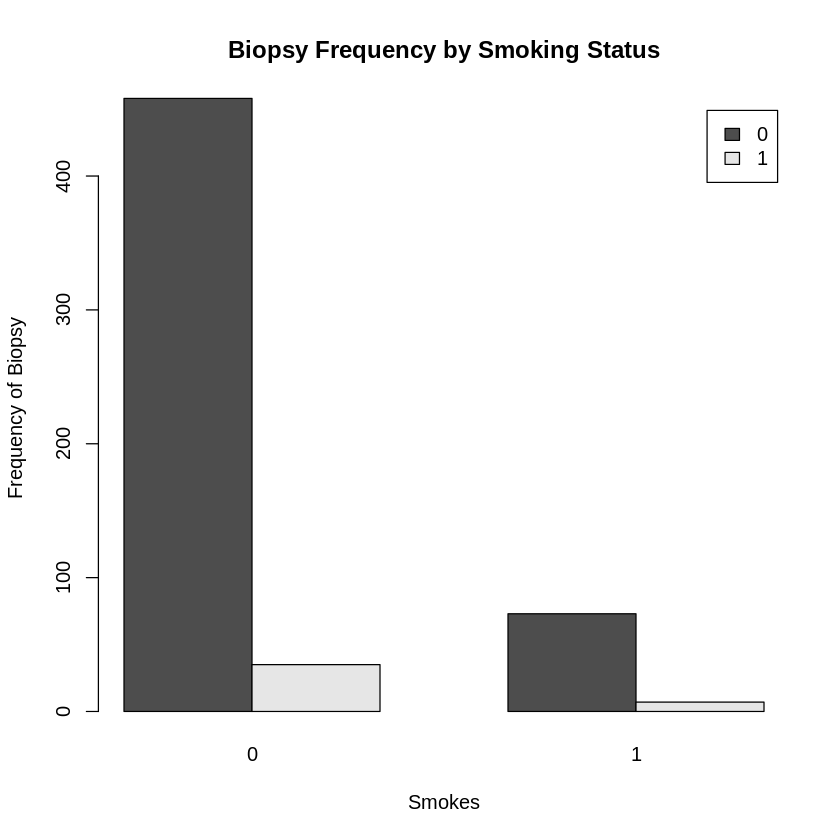

In [554]:
frequency_table <- table(cervical_train$Biopsy, cervical_train$Smokes)

barplot(frequency_table,
        beside = TRUE,
        legend.text = TRUE,
        xlab = "Smokes",
        ylab = "Frequency of Biopsy",
        main = "Biopsy Frequency by Smoking Status")

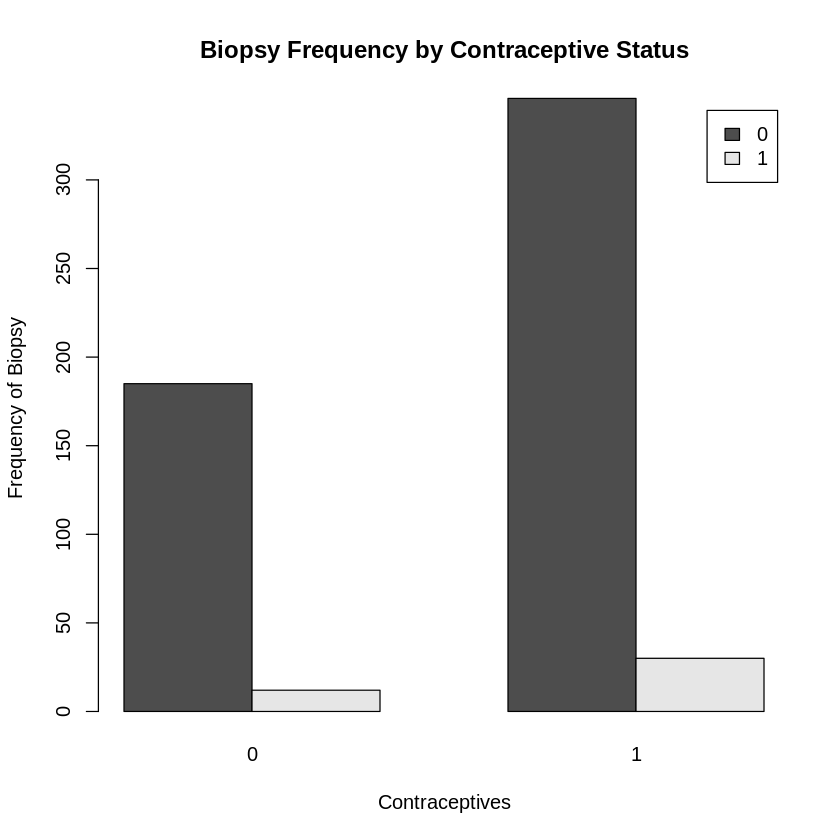

In [555]:
frequency_table <- table(cervical_train$Biopsy, cervical_train$Hormonal.Contraceptives)

barplot(frequency_table,
        beside = TRUE,
        legend.text = TRUE,
        xlab = "Contraceptives",
        ylab = "Frequency of Biopsy",
        main = "Biopsy Frequency by Contraceptive Status")

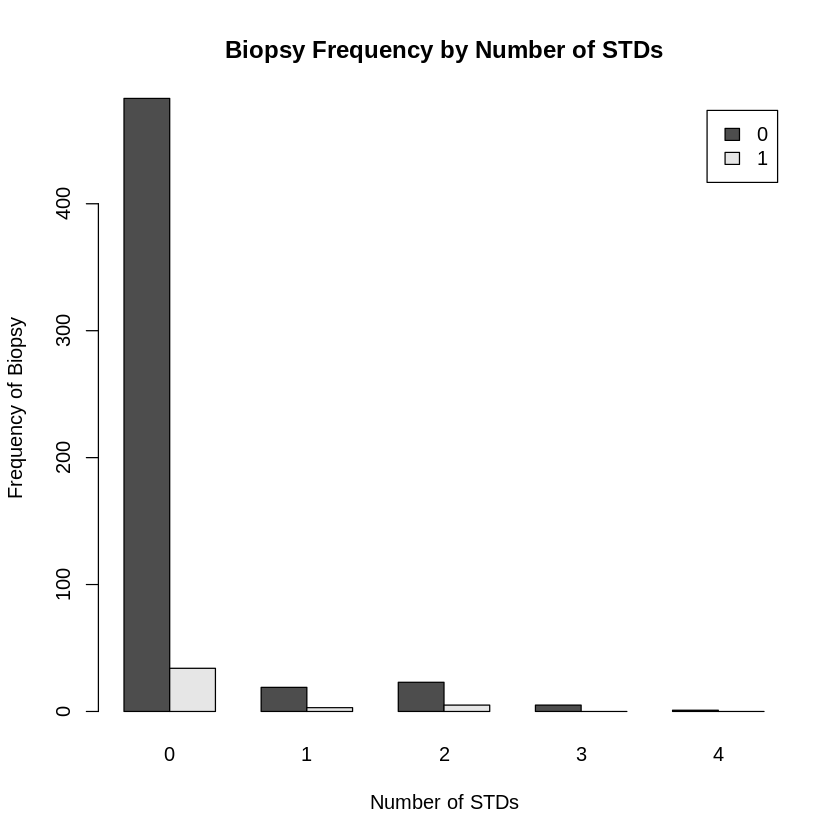

In [556]:
frequency_table <- table(cervical_train$Biopsy, cervical_train$STDs..number.)

barplot(frequency_table,
        beside = TRUE,
        legend.text = TRUE,
        xlab = "Number of STDs",
        ylab = "Frequency of Biopsy",
        main = "Biopsy Frequency by Number of STDs")

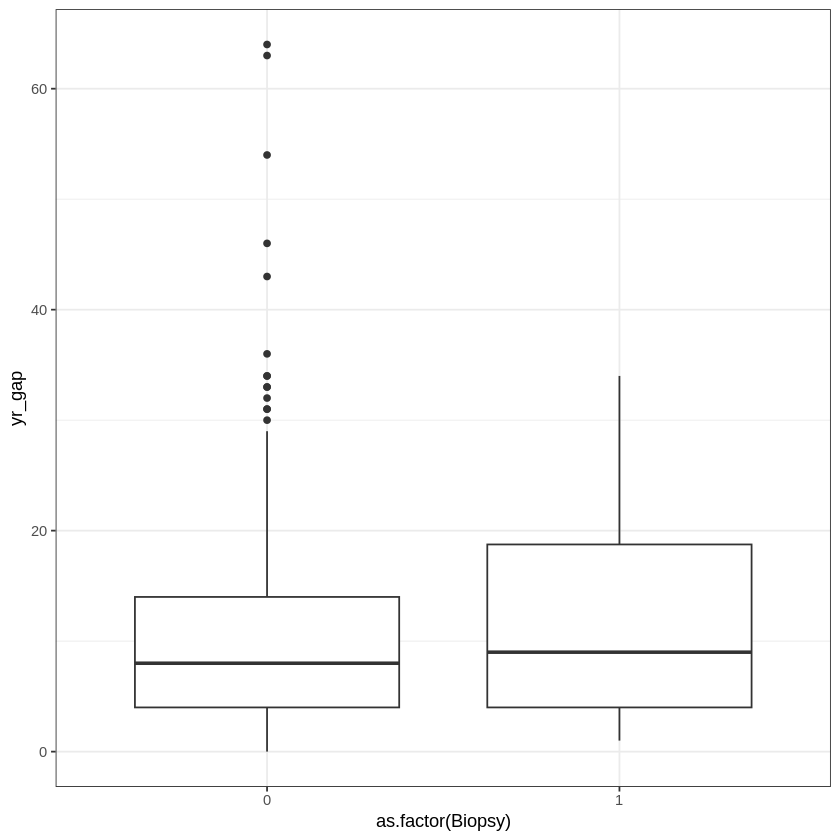

In [557]:
p6 <- ggplot(cervical_train, aes(x=as.factor(Biopsy), y=yr_gap)) +
    geom_boxplot() + theme_bw()
p6

## **Modeling**

### **Logistic Regression**

In [558]:
#Model development
base <- glm(Biopsy~ Age,data=cervical_train,family=binomial())
model1 <- glm(Biopsy~ Age + Number.of.sexual.partners,data=cervical_train,family=binomial())
model2 <- glm(Biopsy~ Age + Number.of.sexual.partners	+ Hormonal.Contraceptives,data=cervical_train,family=binomial())
model3 <- glm(Biopsy~ yr_gap + STDs..number.,data=cervical_train,family=binomial())
model4 <- glm(Biopsy~ Age + Number.of.sexual.partners	+ Hormonal.Contraceptives + Smokes + STDs..number. + First.sexual.intercourse,data=cervical_train,family=binomial())
model5 <- glm(Biopsy~ yr_gap + Number.of.sexual.partners	+ Hormonal.Contraceptives + Smokes + STDs..number. + First.sexual.intercourse,data=cervical_train,family=binomial())

deviance(base)
deviance(model1)
deviance(model2)
deviance(model3)
deviance(model4)
deviance(model5)

stargazer(base,model1,model2,model3,model4,model5,type = "text")

[1] 298.672

[1] 297.9455

[1] 297.2313

[1] 296.0785

[1] 294.1827

[1] 294.1827


                                             Dependent variable:                   
                          ---------------------------------------------------------
                                                   Biopsy                          
                             (1)       (2)       (3)       (4)      (5)      (6)   
-----------------------------------------------------------------------------------
Age                         0.021     0.022     0.023              0.026           
                           (0.015)   (0.015)   (0.016)            (0.017)          
                                                                                   
Number.of.sexual.partners            -0.108    -0.117              -0.140   -0.140 
                                     (0.135)   (0.137)            (0.145)  (0.145) 
                                                                                   
Hormonal.Contraceptives                         0.295              0.337   

In [559]:
coef.table = summary(model5)$coefficients[,c('Estimate', 'Std. Error')]
coef.table = cbind(coef.table, 'Odds ratio' = as.vector(exp(round(coef.table[, c('Estimate')], 2))))
coef.table

,Estimate,Std. Error,Odds ratio
(Intercept),-2.64537349,1.11717900,0.07065121
yr_gap,0.02617283,0.01664010,1.03045453
Number.of.sexual.partners,-0.14017728,0.14525863,0.86935824
Hormonal.Contraceptives,0.33680811,0.35813181,1.40494759
Smokes,0.19347366,0.45379013,1.20924960
STDs..number.,0.36693015,0.22472522,1.44773461
First.sexual.intercourse,-0.01093909,0.05736801,0.99004983


In [560]:
summary(model5)


Call:
glm(formula = Biopsy ~ yr_gap + Number.of.sexual.partners + Hormonal.Contraceptives + 
    Smokes + STDs..number. + First.sexual.intercourse, family = binomial(), 
    data = cervical_train)

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)  
(Intercept)               -2.64537    1.11718  -2.368   0.0179 *
yr_gap                     0.02617    0.01664   1.573   0.1157  
Number.of.sexual.partners -0.14018    0.14526  -0.965   0.3345  
Hormonal.Contraceptives    0.33681    0.35813   0.940   0.3470  
Smokes                     0.19347    0.45379   0.426   0.6699  
STDs..number.              0.36693    0.22473   1.633   0.1025  
First.sexual.intercourse  -0.01094    0.05737  -0.191   0.8488  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 300.35  on 572  degrees of freedom
Residual deviance: 294.18  on 566  degrees of freedom
AIC: 308.18

Number of Fisher Sco

In [561]:
lr2_train <- cervical_train
lr2_train$rt2 <- predict(model5)
lr2_train$rt2 <- ifelse(lr2_train$rt2<0.5,0,1)
lr2_train$Biopsy = factor(lr2_train$Biopsy, levels = c(0, 1), labels=c('Healthy', 'Cancer'))
lr2_train$rt2 = factor(lr2_train$rt2, levels = c(0, 1), labels=c('Healthy', 'Cancer'))
table("Test"=lr2_train$Biopsy,"Predict"=lr2_train$rt2)

         Predict
Test      Healthy Cancer
  Healthy     531      0
  Cancer       42      0

### **Generalized Additive Model**

In [562]:
#Model development
base <- gam(Biopsy ~ s(yr_gap), data = cervical_train, family = binomial())
mod1 <- gam(Biopsy ~ s(yr_gap) + Number.of.sexual.partners	+ Hormonal.Contraceptives, data = cervical_train, family = binomial())
mod2 <- gam(Biopsy ~ s(yr_gap) + Number.of.sexual.partners	+ Hormonal.Contraceptives + Smokes, data = cervical_train, family = binomial())
mod3 <- gam(Biopsy ~ s(yr_gap) + Number.of.sexual.partners	+ Hormonal.Contraceptives + Smokes + STDs..number., data = cervical_train, family = binomial())
mod4 <- gam(Biopsy ~ s(yr_gap) + Number.of.sexual.partners	+ Hormonal.Contraceptives + Smokes + STDs..number. + First.sexual.intercourse, data = cervical_train, family = binomial())
mod5 <- gam(Biopsy ~ s(yr_gap) + Number.of.sexual.partners	+ Hormonal.Contraceptives + Smokes + STDs..number. + s(First.sexual.intercourse), data = cervical_train, family = binomial())

deviance(base)
deviance(mod1)
deviance(mod2)
deviance(mod3)
deviance(mod4)
deviance(mod5)

[1] 296.1479

[1] 296.8919

[1] 294.0906

[1] 291.6168

[1] 291.6786

[1] 287.311

In [563]:
summary(mod5)


Family: binomial 
Link function: logit 

Formula:
Biopsy ~ s(yr_gap) + Number.of.sexual.partners + Hormonal.Contraceptives + 
    Smokes + STDs..number. + s(First.sexual.intercourse)

Parametric coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -2.5728     0.4561  -5.641 1.69e-08 ***
Number.of.sexual.partners  -0.1384     0.1495  -0.926   0.3544    
Hormonal.Contraceptives     0.2839     0.3707   0.766   0.4437    
Smokes                      0.2610     0.4580   0.570   0.5687    
STDs..number.               0.3861     0.2277   1.696   0.0899 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                              edf Ref.df Chi.sq p-value
s(yr_gap)                   2.385  3.015  3.834   0.288
s(First.sexual.intercourse) 3.286  4.149  2.936   0.646

R-sq.(adj) =  0.00919   Deviance explained = 4.34%
UBRE = -0.46134  Scale est. = 1         n = 573

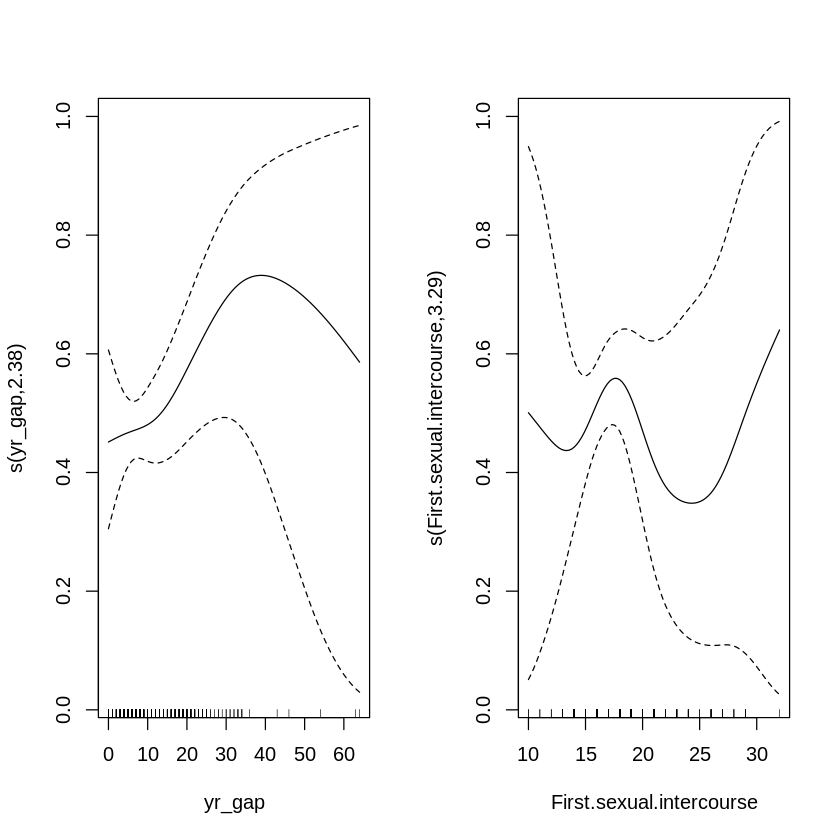

In [564]:
plot(mod5,pages = 1, trans = plogis)

In [565]:
gam2_train <- cervical_train
gam2_train$rt2 <- predict(mod5)
gam2_train$rt2 <- ifelse(gam2_train$rt2<0.5,0,1)
gam2_train$Biopsy = factor(gam2_train$Biopsy, levels = c(0, 1), labels=c('Healthy', 'Cancer'))
gam2_train$rt2 = factor(gam2_train$rt2, levels = c(0, 1), labels=c('Healthy', 'Cancer'))
table("Test"=gam2_train$Biopsy,"Predict"=gam2_train$rt2)

         Predict
Test      Healthy Cancer
  Healthy     531      0
  Cancer       42      0

### **Classification Tree, no boosting nor bagging**

In [566]:
#Model development
base <- rpart(Biopsy ~ . - Age,data=cervical_train, method = 'anova', control = rpart.control(cp = 0, maxdepth = 4,parms = list(split = "information")))
m1 <- rpart(Biopsy ~ Age + Number.of.sexual.partners,data=cervical_train, method = 'anova', control = rpart.control(cp = 0, maxdepth = 3))
m2 <- rpart(Biopsy ~ Age + Number.of.sexual.partners	+ Hormonal.Contraceptives,data=cervical_train, method = 'anova', control = rpart.control(cp = 0, maxdepth = 3))
m3 <- rpart(Biopsy ~ yr_gap + STDs..number.,data=cervical_train, method = 'anova', control = rpart.control(cp = 0, maxdepth = 3))
m4 <- rpart(Biopsy ~ Age + Number.of.sexual.partners	+ Hormonal.Contraceptives + Smokes + STDs..number. + First.sexual.intercourse,data=cervical_train, method = 'anova', control = rpart.control(cp = 0, maxdepth = 3))
m5 <- rpart(Biopsy ~ yr_gap + Number.of.sexual.partners	+ Hormonal.Contraceptives + Smokes + STDs..number. + First.sexual.intercourse,data=cervical_train, method = 'anova', control = rpart.control(cp = 0, maxdepth = 3))
m6 <- rpart(Biopsy ~ yr_gap + STDs..number. + First.sexual.intercourse + Smokes,data=cervical_train, method = 'anova', control = rpart.control(cp = 0,maxdepth = 4,parms = list(split = "information")))

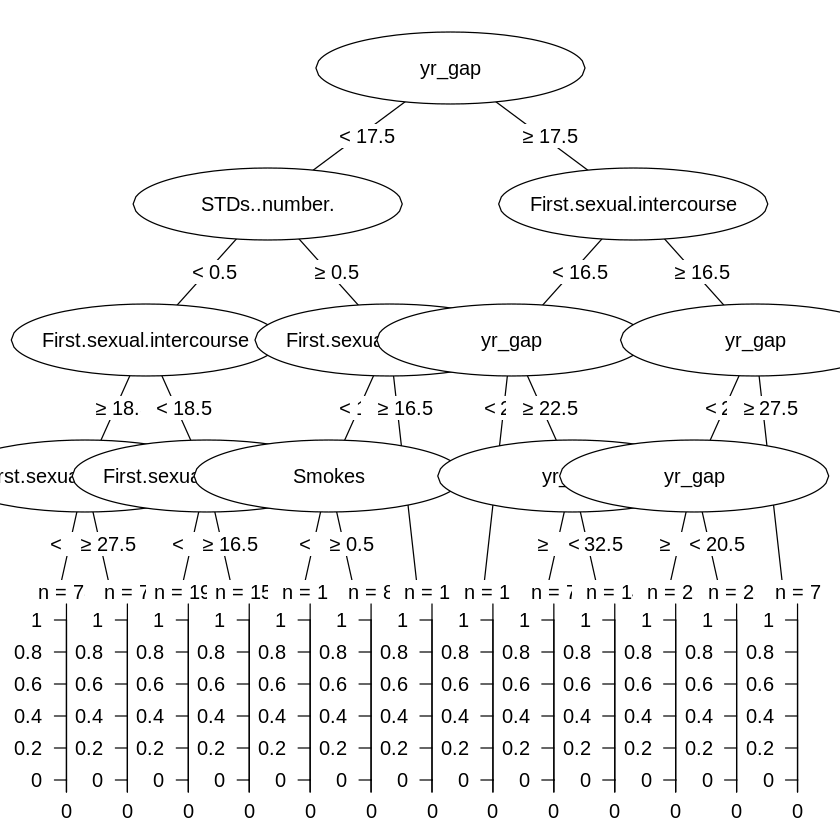

In [567]:
xp <- as.party(base)
plot(xp, digits = 0, id = FALSE, terminal_panel = node_barplot(xp,id = FALSE),
  inner_panel = node_inner(xp, id = FALSE, pval = FALSE)
  )

In [568]:
summary(base)

Call:
rpart(formula = Biopsy ~ . - Age, data = cervical_train, method = "anova", 
    control = rpart.control(cp = 0, maxdepth = 4, parms = list(split = "information")))
  n= 573 

           CP nsplit rel error   xerror      xstd
1 0.010700575      0 1.0000000 1.002946 0.1371733
2 0.010424413      1 0.9892994 1.051344 0.1384637
3 0.009282730      3 0.9684506 1.059435 0.1386821
4 0.005215824      6 0.9395776 1.073356 0.1399680
5 0.004677120      8 0.9291459 1.091898 0.1416869
6 0.003368127      9 0.9244688 1.093915 0.1417535
7 0.003141686     10 0.9211007 1.097264 0.1421374
8 0.002141064     11 0.9179590 1.096373 0.1416641
9 0.000000000     12 0.9158179 1.095245 0.1414791

Variable importance
                   yr_gap  First.sexual.intercourse             STDs..number. 
                       49                        32                         9 
Number.of.sexual.partners                    Smokes   Hormonal.Contraceptives 
                        6                         3          

In [569]:
print(as.party(m6))


Model formula:
Biopsy ~ yr_gap + STDs..number. + First.sexual.intercourse + 
    Smokes

Fitted party:
[1] root
|   [2] yr_gap < 17.5
|   |   [3] STDs..number. < 0.5
|   |   |   [4] First.sexual.intercourse >= 18.5
|   |   |   |   [5] First.sexual.intercourse < 27.5: 0.000 (n = 78, err = 0.0)
|   |   |   |   [6] First.sexual.intercourse >= 27.5: 0.143 (n = 7, err = 0.9)
|   |   |   [7] First.sexual.intercourse < 18.5
|   |   |   |   [8] First.sexual.intercourse < 16.5: 0.047 (n = 193, err = 8.6)
|   |   |   |   [9] First.sexual.intercourse >= 16.5: 0.084 (n = 154, err = 11.9)
|   |   [10] STDs..number. >= 0.5
|   |   |   [11] First.sexual.intercourse < 16.5
|   |   |   |   [12] Smokes < 0.5: 0.000 (n = 16, err = 0.0)
|   |   |   |   [13] Smokes >= 0.5: 0.125 (n = 8, err = 0.9)
|   |   |   [14] First.sexual.intercourse >= 16.5: 0.263 (n = 19, err = 3.7)
|   [15] yr_gap >= 17.5
|   |   [16] First.sexual.intercourse < 16.5
|   |   |   [17] yr_gap < 22.5: 0.000 (n = 17, err = 0.0)
|   |  

In [570]:
describe(cervical_train[cervical_train$First.sexual.intercourse<16.5,])

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Age,1,255,24.52549020,9.3167330,21,23.092682927,5.9304,13,79,66,2.0603787,6.5464202,0.58343645
Number.of.sexual.partners,2,255,2.67450980,2.0486065,2,2.453658537,1.4826,1,28,27,7.5619627,89.1486298,0.12828872
First.sexual.intercourse,3,255,14.93725490,1.0175547,15,15.068292683,1.4826,10,16,6,-1.6616581,4.7317866,0.06372175
Smokes,4,255,0.18431373,0.3885023,0,0.107317073,0.0000,0,1,1,1.6187716,0.6229104,0.02432896
Hormonal.Contraceptives,5,255,0.60784314,0.4891915,1,0.634146341,0.0000,0,1,1,-0.4391745,-1.8141941,0.03063436
STDs..number.,6,255,0.18039216,0.5876081,0,0.009756098,0.0000,0,4,4,3.6538619,14.0453678,0.03679745
Biopsy,7,255,0.05098039,0.2203903,0,0.000000000,0.0000,0,1,1,4.0587886,14.5307941,0.01380137
yr_gap,8,255,9.58823529,9.2650738,7,8.092682927,7.4130,0,63,63,2.0646877,6.3319776,0.58020143


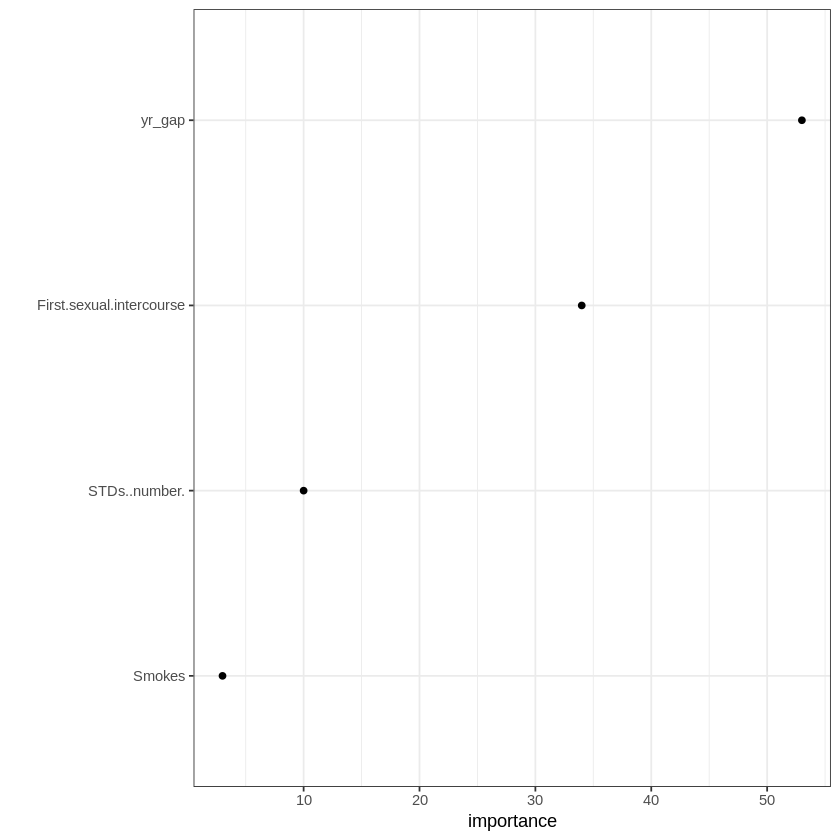

In [571]:
imp = round(100 * m6$variable.importance / sum(m6$variable.importance),0)
imp.df = data.frame(feature = names(imp), importance = imp)
imp.df$feature = factor(imp.df$feature, levels = as.character(imp.df$feature)[order(imp.df$importance)])
ggplot(imp.df) + geom_point(aes(x = importance, y = feature)) +
  scale_y_discrete("") + theme_bw()

In [572]:
rt2_train <- cervical_train
rt2_train$rt2 <- predict(base)
rt2_train$rt2 <- ifelse(rt2_train$rt2<0.5,0,1)
rt2_train$Biopsy = factor(rt2_train$Biopsy, levels = c(0, 1), labels=c('Healthy', 'Cancer'))
rt2_train$rt2 = factor(rt2_train$rt2, levels = c(0, 1), labels=c('Healthy', 'Cancer'))
table("Test"=rt2_train$Biopsy,"Predict"=rt2_train$rt2)

         Predict
Test      Healthy Cancer
  Healthy     531      0
  Cancer       42      0

##Test data

In [573]:
cervical_test$Biopsy = factor(cervical_test$Biopsy, levels = c(0, 1), labels=c('Healthy', 'Cancer'))
cervical_test$lm2 <- predict(model5, newdata = cervical_test, type = "response")
cervical_test$gam2 <- predict(mod5, newdata = cervical_test, type = "response")
cervical_test$rt2 <- predict(m6, newdata = cervical_test)
head(cervical_test)

,Age,Number.of.sexual.partners,First.sexual.intercourse,Smokes,Hormonal.Contraceptives,STDs..number.,Biopsy,yr_gap,lm2,gam2,rt2
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl[1d]>,<dbl>
687,35,5,19,0,0,0,Cancer,16,0.04167293,0.04450470,0.00000000
688,33,3,16,1,1,1,Cancer,17,0.13024653,0.13601229,0.12500000
689,28,5,15,0,0,0,Cancer,13,0.04030657,0.03263188,0.04663212
690,24,1,21,0,1,0,Healthy,3,0.06914195,0.05102168,0.00000000
691,15,1,14,0,1,0,Healthy,1,0.07071767,0.05524162,0.04663212
692,26,2,17,1,1,2,Healthy,9,0.16631181,0.19510415,0.26315789


In [574]:
#Probability threshold at 50
cervical_test$lm2a <- ifelse(cervical_test$lm2<0.5,0,1)
cervical_test$gam2a <- ifelse(cervical_test$lm2<0.5,0,1)
cervical_test$rt2a <- ifelse(cervical_test$lm2<0.5,0,1)

cervical_test$lm2a = factor(cervical_test$lm2a, levels = c(0, 1), labels=c('Healthy', 'Cancer'))
cervical_test$gam2a = factor(cervical_test$gam2a, levels = c(0, 1), labels=c('Healthy', 'Cancer'))
cervical_test$rt2a = factor(cervical_test$rt2a, levels = c(0, 1), labels=c('Healthy', 'Cancer'))

head(cervical_test)

,Age,Number.of.sexual.partners,First.sexual.intercourse,Smokes,Hormonal.Contraceptives,STDs..number.,Biopsy,yr_gap,lm2,gam2,rt2,lm2a,gam2a,rt2a
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl[1d]>,<dbl>,<fct>,<fct>,<fct>
687,35,5,19,0,0,0,Cancer,16,0.04167293,0.04450470,0.00000000,Healthy,Healthy,Healthy
688,33,3,16,1,1,1,Cancer,17,0.13024653,0.13601229,0.12500000,Healthy,Healthy,Healthy
689,28,5,15,0,0,0,Cancer,13,0.04030657,0.03263188,0.04663212,Healthy,Healthy,Healthy
690,24,1,21,0,1,0,Healthy,3,0.06914195,0.05102168,0.00000000,Healthy,Healthy,Healthy
691,15,1,14,0,1,0,Healthy,1,0.07071767,0.05524162,0.04663212,Healthy,Healthy,Healthy
692,26,2,17,1,1,2,Healthy,9,0.16631181,0.19510415,0.26315789,Healthy,Healthy,Healthy


In [575]:
table("Test"=cervical_test$Biopsy,"Predict"=cervical_test$lm2a)

         Predict
Test      Healthy Cancer
  Healthy     129      0
  Cancer        9      0

In [576]:
table("Test"=cervical_test$Biopsy,"Predict"=cervical_test$gam2a)

         Predict
Test      Healthy Cancer
  Healthy     129      0
  Cancer        9      0

In [577]:
table("Test"=cervical_test$Biopsy,"Predict"=cervical_test$rt2a)

         Predict
Test      Healthy Cancer
  Healthy     129      0
  Cancer        9      0

In [578]:
#Probability threshold at 30
cervical_test$lm2b <- ifelse(cervical_test$lm2<0.3,0,1)
cervical_test$gam2b <- ifelse(cervical_test$lm2<0.3,0,1)
cervical_test$rt2b <- ifelse(cervical_test$lm2<0.3,0,1)

cervical_test$lm2b = factor(cervical_test$lm2b, levels = c(0, 1), labels=c('Healthy', 'Cancer'))
cervical_test$gam2b = factor(cervical_test$gam2b, levels = c(0, 1), labels=c('Healthy', 'Cancer'))
cervical_test$rt2b = factor(cervical_test$rt2b, levels = c(0, 1), labels=c('Healthy', 'Cancer'))

head(cervical_test)

,Age,Number.of.sexual.partners,First.sexual.intercourse,Smokes,Hormonal.Contraceptives,STDs..number.,Biopsy,yr_gap,lm2,gam2,rt2,lm2a,gam2a,rt2a,lm2b,gam2b,rt2b
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl[1d]>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
687,35,5,19,0,0,0,Cancer,16,0.04167293,0.04450470,0.00000000,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy
688,33,3,16,1,1,1,Cancer,17,0.13024653,0.13601229,0.12500000,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy
689,28,5,15,0,0,0,Cancer,13,0.04030657,0.03263188,0.04663212,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy
690,24,1,21,0,1,0,Healthy,3,0.06914195,0.05102168,0.00000000,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy
691,15,1,14,0,1,0,Healthy,1,0.07071767,0.05524162,0.04663212,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy
692,26,2,17,1,1,2,Healthy,9,0.16631181,0.19510415,0.26315789,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy


In [579]:
table("Test"=cervical_test$Biopsy,"Predict"=cervical_test$lm2b)

         Predict
Test      Healthy Cancer
  Healthy     129      0
  Cancer        9      0

In [580]:
table("Test"=cervical_test$Biopsy,"Predict"=cervical_test$gam2b)

         Predict
Test      Healthy Cancer
  Healthy     129      0
  Cancer        9      0

In [581]:
table("Test"=cervical_test$Biopsy,"Predict"=cervical_test$rt2b)

         Predict
Test      Healthy Cancer
  Healthy     129      0
  Cancer        9      0

In [582]:
#Probability threshold at 10
cervical_test$lm2c <- ifelse(cervical_test$lm2<0.10,0,1)
cervical_test$gam2c <- ifelse(cervical_test$lm2<0.10,0,1)
cervical_test$rt2c <- ifelse(cervical_test$lm2<0.10,0,1)

cervical_test$lm2c = factor(cervical_test$lm2c, levels = c(0, 1), labels=c('Healthy', 'Cancer'))
cervical_test$gam2c = factor(cervical_test$gam2c, levels = c(0, 1), labels=c('Healthy', 'Cancer'))
cervical_test$rt2c = factor(cervical_test$rt2c, levels = c(0, 1), labels=c('Healthy', 'Cancer'))

head(cervical_test)

,Age,Number.of.sexual.partners,First.sexual.intercourse,Smokes,Hormonal.Contraceptives,STDs..number.,Biopsy,yr_gap,lm2,gam2,rt2,lm2a,gam2a,rt2a,lm2b,gam2b,rt2b,lm2c,gam2c,rt2c
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl[1d]>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
687,35,5,19,0,0,0,Cancer,16,0.04167293,0.04450470,0.00000000,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy
688,33,3,16,1,1,1,Cancer,17,0.13024653,0.13601229,0.12500000,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Cancer,Cancer,Cancer
689,28,5,15,0,0,0,Cancer,13,0.04030657,0.03263188,0.04663212,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy
690,24,1,21,0,1,0,Healthy,3,0.06914195,0.05102168,0.00000000,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy
691,15,1,14,0,1,0,Healthy,1,0.07071767,0.05524162,0.04663212,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy
692,26,2,17,1,1,2,Healthy,9,0.16631181,0.19510415,0.26315789,Healthy,Healthy,Healthy,Healthy,Healthy,Healthy,Cancer,Cancer,Cancer


In [583]:
table("Test"=cervical_test$Biopsy,"Predict"=cervical_test$lm2c)

         Predict
Test      Healthy Cancer
  Healthy     120      9
  Cancer        6      3

In [584]:
table("Test"=cervical_test$Biopsy,"Predict"=cervical_test$gam2c)

         Predict
Test      Healthy Cancer
  Healthy     120      9
  Cancer        6      3

In [585]:
table("Test"=cervical_test$Biopsy,"Predict"=cervical_test$rt2c)

         Predict
Test      Healthy Cancer
  Healthy     120      9
  Cancer        6      3